# Exploration Test sandbox

In [1]:
%matplotlib notebook

import argparse
import sys
from tqdm import trange

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
np.set_printoptions(precision=4)

import gym
from gym import wrappers, logger

from multigoal_env.multigoal import MultiGoal

from spinup.utils.mpi_tools import mpi_fork, mpi_avg, proc_id, mpi_statistics_scalar, num_procs
from agents import RandomAgent

import torch
import tree

# Multi Goal Environment

## The code for multi goal is written in the `multigoal_env` folder
## The enviroment is registered in `__init__.py` and defined in `multigoal.py`

#### About multigoal environment: The multigoal environment depicts a 2D state space with multimodal rewards. In many applications, we want to learn a policy that achieves high reward via distinct trajectories. The multigoal enviroment is a nice and easy test bed to test various RL algorithms for such multimodal reward setting.



In [20]:
%matplotlib notebook

import argparse
import sys
from tqdm import trange

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
np.set_printoptions(precision=4)

import gym
from gym import wrappers, logger

from multigoal_env.multigoal import MultiGoal

from spinup.utils.mpi_tools import mpi_fork, mpi_avg, proc_id, mpi_statistics_scalar, num_procs
from agents import RandomAgent

import torch
import tree

env_id = 'MultiGoal-v0'
seed = 1234

In [21]:
def process_sample(observation, action,reward, 
                    terminal,next_observation,info):
    
    processed_observation = {
        'observations': observation,
        'actions': action,
        'rewards': np.atleast_1d(reward),
        'terminals': np.atleast_1d(terminal),
        'next_observations': next_observation,
        'infos': info,
    }

    return processed_observation

def test_policy(agent_fun):
    
    env = gym.make(env_id)
    env.seed(seed)
    reward = 0.
    done = False
    agent = agent_fun(env)
    current_path = []
    
    path_length = 0
    path_return = 0.
    num_episodes = 10
    max_steps = 50
    all_paths = []
    total_rewards = []
    
    for episode in range(1, num_episodes+1):

        current_ob = env.reset()
        rewards = []

        while True:
            ob_tensor = torch.as_tensor(current_ob, dtype=torch.float32)
            action = agent.act(ob_tensor)
            
            ob, reward, done, info = env.step(action)

            processed_sample = process_sample(observation=current_ob, action=action, reward=reward,
                                              terminal=done, next_observation=ob,info=info)

            rewards.append(reward)
            current_path.append(processed_sample)

            path_length += 1

            if done or path_length > max_steps:
                current_ob = env.reset()
                path_length = 0
                last_path = tree.map_structure(lambda *x: np.stack(x, axis=0), *current_path)
                all_paths.append(last_path)
                env.render_rollouts(all_paths)
                current_path = []

                break
            else:
                current_ob = ob    
            
        total_rewards.append((np.sum(rewards), np.mean(rewards)))
#         if episode % 5 == 0:
#             print ('Episode Number: {:d} | Total Reward: {:.4f} '.format(episode, np.sum(rewards)))

    env.close()
    total_rewards = tree.map_structure(lambda *x: np.stack(x, axis=0), *total_rewards)
    return total_rewards

# Random Agent

<IPython.core.display.Javascript object>


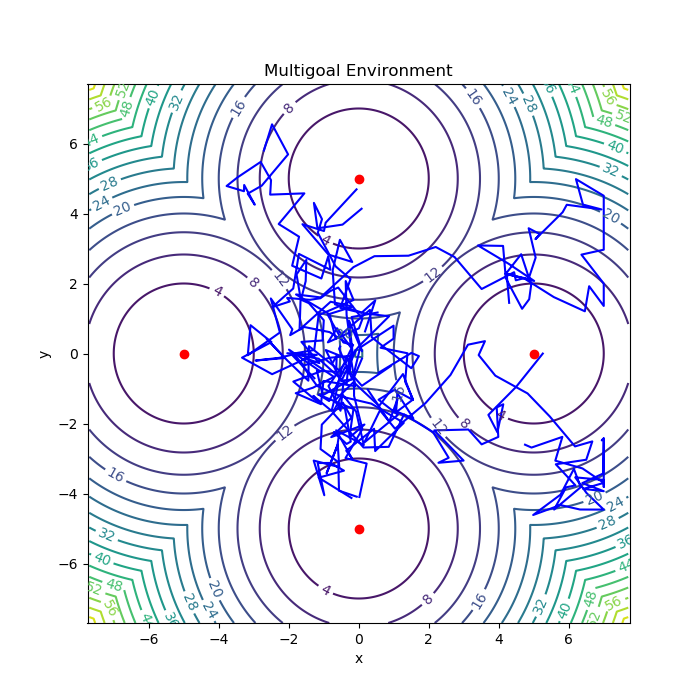

Average Reward across 10 episodes is -1010.91
Reward per step of the particle is -29.27


In [19]:
agent = lambda env: RandomAgent(env.action_space)
total_rewards = test_policy(agent)
print ('Average Reward across {:d} episodes is {:.2f}'.format(total_rewards[0].shape[0], np.mean(total_rewards[0])))
print ('Reward per step of the particle is {:.2f}'.format(np.mean(total_rewards[1])))

# Policy Gradient 

In [3]:
hid = 10
num_layers = 2
gamma = 0.9
num_epochs = 500
cpu = 2

MAX_STEPS_PER_EPISODE = 100
steps = MAX_STEPS_PER_EPISODE
seed = 37

In [4]:
from spinup.utils.run_utils import setup_logger_kwargs
logger_kwargs = setup_logger_kwargs('vpg', seed, data_dir='model/')
from algos.vpg_source.custom_actor_critic import MLPActorCritic
from algos.vpg_source.vpg import vpg as vpg_pytorch

In [15]:
epoch_reward = vpg_pytorch(lambda : gym.make(env_id), actor_critic=MLPActorCritic,
                            ac_kwargs=dict(hidden_sizes=[hid]*num_layers), gamma=gamma, 
                            seed=seed, steps_per_epoch=steps, epochs=num_epochs,
                            logger_kwargs=logger_kwargs, max_ep_len=MAX_STEPS_PER_EPISODE)

Logging data to model/vpg/vpg_s37/progress.txt
Saving config:

{
    "ac_kwargs":	{
        "hidden_sizes":	[
            10,
            10
        ]
    },
    "actor_critic":	"MLPActorCritic",
    "env_fn":	"<function <lambda> at 0x7f2ab2a13dd0>",
    "epochs":	500,
    "exp_name":	"vpg",
    "gamma":	0.9,
    "lam":	0.97,
    "logger":	{
        "<spinup.utils.logx.EpochLogger object at 0x7f2ad44aa690>":	{
            "epoch_dict":	{},
            "exp_name":	"vpg",
            "first_row":	true,
            "log_current_row":	{},
            "log_headers":	[],
            "output_dir":	"model/vpg/vpg_s37",
            "output_file":	{
                "<_io.TextIOWrapper name='model/vpg/vpg_s37/progress.txt' mode='w' encoding='UTF-8'>":	{
                    "mode":	"w"
                }
            }
        }
    },
    "logger_kwargs":	{
        "exp_name":	"vpg",
        "output_dir":	"model/vpg/vpg_s37"
    },
    "max_ep_len":	100,
    "pi_lr":	0.0003,
    "save_freq":	10,
  

/opt/conda/lib/python3.7/site-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


---------------------------------------
|             Epoch |              10 |
|      AverageEpRet |       -1.12e+03 |
|          StdEpRet |             913 |
|          MaxEpRet |            -382 |
|          MinEpRet |       -3.37e+03 |
|             EpLen |              37 |
|      AverageVVals |           -6.81 |
|          StdVVals |            3.89 |
|          MaxVVals |            2.31 |
|          MinVVals |           -12.6 |
| TotalEnvInteracts |         1.1e+03 |
|            LossPi |         -0.0757 |
|             LossV |        6.81e+04 |
|       DeltaLossPi |               0 |
|        DeltaLossV |            -735 |
|           Entropy |           0.919 |
|                KL |       -2.62e-09 |
|              Time |            3.72 |
---------------------------------------


/opt/conda/lib/python3.7/site-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


---------------------------------------
|             Epoch |              20 |
|      AverageEpRet |       -1.15e+03 |
|          StdEpRet |        1.06e+03 |
|          MaxEpRet |            -190 |
|          MinEpRet |       -3.31e+03 |
|             EpLen |            39.9 |
|      AverageVVals |           -17.5 |
|          StdVVals |            2.48 |
|          MaxVVals |           -13.5 |
|          MinVVals |           -21.5 |
| TotalEnvInteracts |         2.1e+03 |
|            LossPi |          -0.161 |
|             LossV |         5.6e+04 |
|       DeltaLossPi |               0 |
|        DeltaLossV |            -386 |
|           Entropy |           0.917 |
|                KL |       -3.34e-09 |
|              Time |            7.26 |
---------------------------------------


/opt/conda/lib/python3.7/site-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


---------------------------------------
|             Epoch |              30 |
|      AverageEpRet |       -1.28e+03 |
|          StdEpRet |             932 |
|          MaxEpRet |            -352 |
|          MinEpRet |       -3.49e+03 |
|             EpLen |            43.2 |
|      AverageVVals |           -25.8 |
|          StdVVals |            2.82 |
|          MaxVVals |           -7.48 |
|          MinVVals |           -29.7 |
| TotalEnvInteracts |         3.1e+03 |
|            LossPi |          -0.212 |
|             LossV |        5.75e+04 |
|       DeltaLossPi |               0 |
|        DeltaLossV |            -487 |
|           Entropy |           0.916 |
|                KL |       -2.03e-09 |
|              Time |              11 |
---------------------------------------


/opt/conda/lib/python3.7/site-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


---------------------------------------
|             Epoch |              40 |
|      AverageEpRet |            -945 |
|          StdEpRet |             692 |
|          MaxEpRet |            -211 |
|          MinEpRet |       -3.24e+03 |
|             EpLen |            31.6 |
|      AverageVVals |           -34.2 |
|          StdVVals |            2.24 |
|          MaxVVals |           -30.8 |
|          MinVVals |           -37.7 |
| TotalEnvInteracts |         4.1e+03 |
|            LossPi |          -0.134 |
|             LossV |        4.66e+04 |
|       DeltaLossPi |               0 |
|        DeltaLossV |            -315 |
|           Entropy |           0.913 |
|                KL |        1.31e-09 |
|              Time |            14.1 |
---------------------------------------


/opt/conda/lib/python3.7/site-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


---------------------------------------
|             Epoch |              50 |
|      AverageEpRet |            -898 |
|          StdEpRet |             696 |
|          MaxEpRet |            -173 |
|          MinEpRet |       -3.03e+03 |
|             EpLen |            31.5 |
|      AverageVVals |             -42 |
|          StdVVals |            2.09 |
|          MaxVVals |           -38.8 |
|          MinVVals |           -45.6 |
| TotalEnvInteracts |         5.1e+03 |
|            LossPi |          -0.191 |
|             LossV |        3.86e+04 |
|       DeltaLossPi |               0 |
|        DeltaLossV |            -270 |
|           Entropy |           0.911 |
|                KL |       -5.96e-10 |
|              Time |            17.4 |
---------------------------------------


/opt/conda/lib/python3.7/site-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


---------------------------------------
|             Epoch |              60 |
|      AverageEpRet |       -1.28e+03 |
|          StdEpRet |        1.02e+03 |
|          MaxEpRet |            -351 |
|          MinEpRet |       -3.86e+03 |
|             EpLen |              43 |
|      AverageVVals |             -50 |
|          StdVVals |            2.25 |
|          MaxVVals |           -46.4 |
|          MinVVals |           -53.7 |
| TotalEnvInteracts |         6.1e+03 |
|            LossPi |          -0.182 |
|             LossV |        4.33e+04 |
|       DeltaLossPi |               0 |
|        DeltaLossV |            -332 |
|           Entropy |           0.909 |
|                KL |        1.85e-09 |
|              Time |            20.5 |
---------------------------------------


/opt/conda/lib/python3.7/site-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


---------------------------------------
|             Epoch |              70 |
|      AverageEpRet |            -973 |
|          StdEpRet |             791 |
|          MaxEpRet |            -175 |
|          MinEpRet |       -2.85e+03 |
|             EpLen |            34.7 |
|      AverageVVals |           -58.4 |
|          StdVVals |            2.18 |
|          MaxVVals |             -55 |
|          MinVVals |           -61.8 |
| TotalEnvInteracts |         7.1e+03 |
|            LossPi |          -0.156 |
|             LossV |        3.17e+04 |
|       DeltaLossPi |               0 |
|        DeltaLossV |            -244 |
|           Entropy |           0.906 |
|                KL |       -3.16e-09 |
|              Time |            23.7 |
---------------------------------------


/opt/conda/lib/python3.7/site-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


---------------------------------------
|             Epoch |              80 |
|      AverageEpRet |            -763 |
|          StdEpRet |             463 |
|          MaxEpRet |            -303 |
|          MinEpRet |       -1.78e+03 |
|             EpLen |            27.9 |
|      AverageVVals |           -66.1 |
|          StdVVals |             2.3 |
|          MaxVVals |           -62.6 |
|          MinVVals |           -69.7 |
| TotalEnvInteracts |         8.1e+03 |
|            LossPi |          -0.136 |
|             LossV |        3.34e+04 |
|       DeltaLossPi |               0 |
|        DeltaLossV |            -268 |
|           Entropy |           0.904 |
|                KL |       -1.19e-10 |
|              Time |            26.9 |
---------------------------------------


/opt/conda/lib/python3.7/site-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


---------------------------------------
|             Epoch |              90 |
|      AverageEpRet |       -1.11e+03 |
|          StdEpRet |             789 |
|          MaxEpRet |            -302 |
|          MinEpRet |       -3.67e+03 |
|             EpLen |              39 |
|      AverageVVals |           -74.2 |
|          StdVVals |            2.12 |
|          MaxVVals |           -70.8 |
|          MinVVals |           -77.6 |
| TotalEnvInteracts |         9.1e+03 |
|            LossPi |         -0.0898 |
|             LossV |        2.88e+04 |
|       DeltaLossPi |               0 |
|        DeltaLossV |            -228 |
|           Entropy |           0.902 |
|                KL |        1.19e-10 |
|              Time |            30.2 |
---------------------------------------


/opt/conda/lib/python3.7/site-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


---------------------------------------
|             Epoch |             100 |
|      AverageEpRet |       -1.13e+03 |
|          StdEpRet |             801 |
|          MaxEpRet |            -291 |
|          MinEpRet |       -3.35e+03 |
|             EpLen |            39.4 |
|      AverageVVals |             -82 |
|          StdVVals |            2.35 |
|          MaxVVals |           -78.3 |
|          MinVVals |           -85.6 |
| TotalEnvInteracts |        1.01e+04 |
|            LossPi |           -0.19 |
|             LossV |        2.97e+04 |
|       DeltaLossPi |               0 |
|        DeltaLossV |            -247 |
|           Entropy |           0.901 |
|                KL |        2.21e-09 |
|              Time |            33.4 |
---------------------------------------


/opt/conda/lib/python3.7/site-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


---------------------------------------
|             Epoch |             110 |
|      AverageEpRet |            -714 |
|          StdEpRet |             502 |
|          MaxEpRet |            -206 |
|          MinEpRet |       -2.59e+03 |
|             EpLen |            26.2 |
|      AverageVVals |             -89 |
|          StdVVals |            1.92 |
|          MaxVVals |           -86.4 |
|          MinVVals |           -92.3 |
| TotalEnvInteracts |        1.11e+04 |
|            LossPi |          -0.143 |
|             LossV |         1.8e+04 |
|       DeltaLossPi |               0 |
|        DeltaLossV |            -150 |
|           Entropy |           0.899 |
|                KL |        1.25e-09 |
|              Time |            36.7 |
---------------------------------------


/opt/conda/lib/python3.7/site-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


---------------------------------------
|             Epoch |             120 |
|      AverageEpRet |            -889 |
|          StdEpRet |             524 |
|          MaxEpRet |            -261 |
|          MinEpRet |       -2.92e+03 |
|             EpLen |              32 |
|      AverageVVals |           -96.5 |
|          StdVVals |            2.15 |
|          MaxVVals |           -93.1 |
|          MinVVals |           -99.8 |
| TotalEnvInteracts |        1.21e+04 |
|            LossPi |          -0.133 |
|             LossV |        1.78e+04 |
|       DeltaLossPi |               0 |
|        DeltaLossV |            -163 |
|           Entropy |           0.896 |
|                KL |        3.52e-09 |
|              Time |            39.8 |
---------------------------------------


/opt/conda/lib/python3.7/site-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


---------------------------------------
|             Epoch |             130 |
|      AverageEpRet |            -620 |
|          StdEpRet |             308 |
|          MaxEpRet |            -159 |
|          MinEpRet |       -1.49e+03 |
|             EpLen |            21.7 |
|      AverageVVals |            -104 |
|          StdVVals |            2.17 |
|          MaxVVals |            -101 |
|          MinVVals |            -107 |
| TotalEnvInteracts |        1.31e+04 |
|            LossPi |          -0.162 |
|             LossV |        1.66e+04 |
|       DeltaLossPi |               0 |
|        DeltaLossV |            -144 |
|           Entropy |           0.894 |
|                KL |        2.98e-09 |
|              Time |              43 |
---------------------------------------


/opt/conda/lib/python3.7/site-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


---------------------------------------
|             Epoch |             140 |
|      AverageEpRet |            -941 |
|          StdEpRet |             838 |
|          MaxEpRet |            -245 |
|          MinEpRet |       -3.61e+03 |
|             EpLen |              32 |
|      AverageVVals |            -111 |
|          StdVVals |            2.59 |
|          MaxVVals |            -108 |
|          MinVVals |            -116 |
| TotalEnvInteracts |        1.41e+04 |
|            LossPi |          -0.111 |
|             LossV |        2.19e+04 |
|       DeltaLossPi |               0 |
|        DeltaLossV |            -229 |
|           Entropy |           0.892 |
|                KL |        4.17e-10 |
|              Time |            46.3 |
---------------------------------------


/opt/conda/lib/python3.7/site-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


---------------------------------------
|             Epoch |             150 |
|      AverageEpRet |            -757 |
|          StdEpRet |             626 |
|          MaxEpRet |            -182 |
|          MinEpRet |       -3.27e+03 |
|             EpLen |            27.4 |
|      AverageVVals |            -119 |
|          StdVVals |            1.84 |
|          MaxVVals |            -116 |
|          MinVVals |            -122 |
| TotalEnvInteracts |        1.51e+04 |
|            LossPi |           -0.14 |
|             LossV |        1.47e+04 |
|       DeltaLossPi |               0 |
|        DeltaLossV |            -134 |
|           Entropy |           0.891 |
|                KL |       -3.93e-09 |
|              Time |            49.4 |
---------------------------------------


/opt/conda/lib/python3.7/site-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


---------------------------------------
|             Epoch |             160 |
|      AverageEpRet |            -565 |
|          StdEpRet |             297 |
|          MaxEpRet |            -194 |
|          MinEpRet |       -1.39e+03 |
|             EpLen |            21.1 |
|      AverageVVals |            -127 |
|          StdVVals |            1.87 |
|          MaxVVals |            -123 |
|          MinVVals |            -129 |
| TotalEnvInteracts |        1.61e+04 |
|            LossPi |          -0.143 |
|             LossV |        1.75e+04 |
|       DeltaLossPi |               0 |
|        DeltaLossV |            -144 |
|           Entropy |           0.889 |
|                KL |       -1.37e-09 |
|              Time |            52.7 |
---------------------------------------


/opt/conda/lib/python3.7/site-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


---------------------------------------
|             Epoch |             170 |
|      AverageEpRet |            -935 |
|          StdEpRet |             724 |
|          MaxEpRet |            -175 |
|          MinEpRet |       -2.72e+03 |
|             EpLen |            33.3 |
|      AverageVVals |            -133 |
|          StdVVals |            2.31 |
|          MaxVVals |            -130 |
|          MinVVals |            -137 |
| TotalEnvInteracts |        1.71e+04 |
|            LossPi |          -0.155 |
|             LossV |        1.38e+04 |
|       DeltaLossPi |               0 |
|        DeltaLossV |            -153 |
|           Entropy |           0.887 |
|                KL |       -7.57e-09 |
|              Time |            55.9 |
---------------------------------------


/opt/conda/lib/python3.7/site-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


---------------------------------------
|             Epoch |             180 |
|      AverageEpRet |            -546 |
|          StdEpRet |             418 |
|          MaxEpRet |            -192 |
|          MinEpRet |        -2.6e+03 |
|             EpLen |              19 |
|      AverageVVals |            -140 |
|          StdVVals |            1.92 |
|          MaxVVals |            -138 |
|          MinVVals |            -144 |
| TotalEnvInteracts |        1.81e+04 |
|            LossPi |          -0.158 |
|             LossV |        1.44e+04 |
|       DeltaLossPi |               0 |
|        DeltaLossV |            -130 |
|           Entropy |           0.885 |
|                KL |        2.03e-09 |
|              Time |            59.2 |
---------------------------------------


/opt/conda/lib/python3.7/site-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


---------------------------------------
|             Epoch |             190 |
|      AverageEpRet |            -662 |
|          StdEpRet |             527 |
|          MaxEpRet |            -215 |
|          MinEpRet |       -2.99e+03 |
|             EpLen |            24.4 |
|      AverageVVals |            -147 |
|          StdVVals |            1.69 |
|          MaxVVals |            -144 |
|          MinVVals |            -149 |
| TotalEnvInteracts |        1.91e+04 |
|            LossPi |           -0.18 |
|             LossV |        1.12e+04 |
|       DeltaLossPi |               0 |
|        DeltaLossV |           -74.4 |
|           Entropy |           0.883 |
|                KL |       -1.49e-09 |
|              Time |            62.4 |
---------------------------------------


/opt/conda/lib/python3.7/site-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


---------------------------------------
|             Epoch |             200 |
|      AverageEpRet |            -546 |
|          StdEpRet |             415 |
|          MaxEpRet |            -186 |
|          MinEpRet |       -2.45e+03 |
|             EpLen |            19.7 |
|      AverageVVals |            -152 |
|          StdVVals |            1.43 |
|          MaxVVals |            -150 |
|          MinVVals |            -154 |
| TotalEnvInteracts |        2.01e+04 |
|            LossPi |          -0.234 |
|             LossV |        1.05e+04 |
|       DeltaLossPi |               0 |
|        DeltaLossV |           -58.4 |
|           Entropy |            0.88 |
|                KL |        1.19e-09 |
|              Time |            65.6 |
---------------------------------------


/opt/conda/lib/python3.7/site-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


---------------------------------------
|             Epoch |             210 |
|      AverageEpRet |            -758 |
|          StdEpRet |             699 |
|          MaxEpRet |            -278 |
|          MinEpRet |       -3.29e+03 |
|             EpLen |            26.9 |
|      AverageVVals |            -158 |
|          StdVVals |            2.66 |
|          MaxVVals |            -154 |
|          MinVVals |            -162 |
| TotalEnvInteracts |        2.11e+04 |
|            LossPi |           -0.15 |
|             LossV |        1.14e+04 |
|       DeltaLossPi |               0 |
|        DeltaLossV |            -150 |
|           Entropy |           0.877 |
|                KL |        4.17e-10 |
|              Time |            68.9 |
---------------------------------------


/opt/conda/lib/python3.7/site-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


---------------------------------------
|             Epoch |             220 |
|      AverageEpRet |            -894 |
|          StdEpRet |             626 |
|          MaxEpRet |            -277 |
|          MinEpRet |       -2.41e+03 |
|             EpLen |            33.3 |
|      AverageVVals |            -164 |
|          StdVVals |            1.63 |
|          MaxVVals |            -162 |
|          MinVVals |            -167 |
| TotalEnvInteracts |        2.21e+04 |
|            LossPi |          -0.154 |
|             LossV |         7.8e+03 |
|       DeltaLossPi |               0 |
|        DeltaLossV |           -49.5 |
|           Entropy |           0.875 |
|                KL |        6.08e-09 |
|              Time |            72.1 |
---------------------------------------


/opt/conda/lib/python3.7/site-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


---------------------------------------
|             Epoch |             230 |
|      AverageEpRet |            -825 |
|          StdEpRet |             825 |
|          MaxEpRet |            -152 |
|          MinEpRet |       -2.96e+03 |
|             EpLen |            30.4 |
|      AverageVVals |            -170 |
|          StdVVals |            1.72 |
|          MaxVVals |            -167 |
|          MinVVals |            -172 |
| TotalEnvInteracts |        2.31e+04 |
|            LossPi |          -0.197 |
|             LossV |         8.6e+03 |
|       DeltaLossPi |               0 |
|        DeltaLossV |           -97.7 |
|           Entropy |           0.872 |
|                KL |        5.96e-10 |
|              Time |            75.3 |
---------------------------------------


/opt/conda/lib/python3.7/site-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


---------------------------------------
|             Epoch |             240 |
|      AverageEpRet |            -627 |
|          StdEpRet |             447 |
|          MaxEpRet |            -264 |
|          MinEpRet |        -2.6e+03 |
|             EpLen |            22.6 |
|      AverageVVals |            -175 |
|          StdVVals |             1.9 |
|          MaxVVals |            -173 |
|          MinVVals |            -179 |
| TotalEnvInteracts |        2.41e+04 |
|            LossPi |          -0.156 |
|             LossV |        8.41e+03 |
|       DeltaLossPi |               0 |
|        DeltaLossV |           -73.1 |
|           Entropy |            0.87 |
|                KL |         2.5e-09 |
|              Time |            78.5 |
---------------------------------------


/opt/conda/lib/python3.7/site-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


---------------------------------------
|             Epoch |             250 |
|      AverageEpRet |            -627 |
|          StdEpRet |             501 |
|          MaxEpRet |            -143 |
|          MinEpRet |        -2.6e+03 |
|             EpLen |            24.2 |
|      AverageVVals |            -179 |
|          StdVVals |           0.164 |
|          MaxVVals |            -179 |
|          MinVVals |            -179 |
| TotalEnvInteracts |        2.51e+04 |
|            LossPi |         -0.0861 |
|             LossV |        6.77e+03 |
|       DeltaLossPi |               0 |
|        DeltaLossV |           -18.2 |
|           Entropy |           0.868 |
|                KL |       -1.19e-10 |
|              Time |            81.7 |
---------------------------------------


/opt/conda/lib/python3.7/site-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


---------------------------------------
|             Epoch |             260 |
|      AverageEpRet |            -638 |
|          StdEpRet |             528 |
|          MaxEpRet |            -219 |
|          MinEpRet |       -2.24e+03 |
|             EpLen |              24 |
|      AverageVVals |            -181 |
|          StdVVals |            1.39 |
|          MaxVVals |            -179 |
|          MinVVals |            -184 |
| TotalEnvInteracts |        2.61e+04 |
|            LossPi |          -0.126 |
|             LossV |        7.15e+03 |
|       DeltaLossPi |               0 |
|        DeltaLossV |           -42.7 |
|           Entropy |           0.866 |
|                KL |        1.07e-09 |
|              Time |            84.9 |
---------------------------------------


/opt/conda/lib/python3.7/site-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


---------------------------------------
|             Epoch |             270 |
|      AverageEpRet |            -662 |
|          StdEpRet |             407 |
|          MaxEpRet |            -185 |
|          MinEpRet |       -2.06e+03 |
|             EpLen |            24.7 |
|      AverageVVals |            -184 |
|          StdVVals |           0.477 |
|          MaxVVals |            -184 |
|          MinVVals |            -185 |
| TotalEnvInteracts |        2.71e+04 |
|            LossPi |          -0.161 |
|             LossV |        7.64e+03 |
|       DeltaLossPi |               0 |
|        DeltaLossV |             -75 |
|           Entropy |           0.864 |
|                KL |       -1.19e-09 |
|              Time |            88.1 |
---------------------------------------


/opt/conda/lib/python3.7/site-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


---------------------------------------
|             Epoch |             280 |
|      AverageEpRet |            -787 |
|          StdEpRet |             699 |
|          MaxEpRet |            -193 |
|          MinEpRet |       -2.87e+03 |
|             EpLen |            29.3 |
|      AverageVVals |            -188 |
|          StdVVals |            1.27 |
|          MaxVVals |            -186 |
|          MinVVals |            -190 |
| TotalEnvInteracts |        2.81e+04 |
|            LossPi |           -0.15 |
|             LossV |         7.7e+03 |
|       DeltaLossPi |               0 |
|        DeltaLossV |           -91.5 |
|           Entropy |           0.862 |
|                KL |        3.58e-10 |
|              Time |            91.3 |
---------------------------------------


/opt/conda/lib/python3.7/site-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


---------------------------------------
|             Epoch |             290 |
|      AverageEpRet |            -466 |
|          StdEpRet |             260 |
|          MaxEpRet |            -169 |
|          MinEpRet |       -1.45e+03 |
|             EpLen |            17.9 |
|      AverageVVals |            -189 |
|          StdVVals |            1.17 |
|          MaxVVals |            -187 |
|          MinVVals |            -191 |
| TotalEnvInteracts |        2.91e+04 |
|            LossPi |          -0.113 |
|             LossV |        7.52e+03 |
|       DeltaLossPi |               0 |
|        DeltaLossV |           -47.9 |
|           Entropy |            0.86 |
|                KL |        2.32e-09 |
|              Time |            94.6 |
---------------------------------------


/opt/conda/lib/python3.7/site-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


---------------------------------------
|             Epoch |             300 |
|      AverageEpRet |            -597 |
|          StdEpRet |             397 |
|          MaxEpRet |            -222 |
|          MinEpRet |       -1.67e+03 |
|             EpLen |            22.1 |
|      AverageVVals |            -187 |
|          StdVVals |           0.983 |
|          MaxVVals |            -186 |
|          MinVVals |            -188 |
| TotalEnvInteracts |        3.01e+04 |
|            LossPi |           -0.12 |
|             LossV |        7.29e+03 |
|       DeltaLossPi |               0 |
|        DeltaLossV |           -33.4 |
|           Entropy |           0.858 |
|                KL |       -3.81e-09 |
|              Time |            97.9 |
---------------------------------------


/opt/conda/lib/python3.7/site-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


---------------------------------------
|             Epoch |             310 |
|      AverageEpRet |            -538 |
|          StdEpRet |             371 |
|          MaxEpRet |            -210 |
|          MinEpRet |       -2.02e+03 |
|             EpLen |            21.5 |
|      AverageVVals |            -187 |
|          StdVVals |           0.828 |
|          MaxVVals |            -186 |
|          MinVVals |            -189 |
| TotalEnvInteracts |        3.11e+04 |
|            LossPi |          -0.159 |
|             LossV |        6.66e+03 |
|       DeltaLossPi |               0 |
|        DeltaLossV |           -58.9 |
|           Entropy |           0.857 |
|                KL |       -4.89e-09 |
|              Time |             101 |
---------------------------------------


/opt/conda/lib/python3.7/site-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


---------------------------------------
|             Epoch |             320 |
|      AverageEpRet |            -605 |
|          StdEpRet |             521 |
|          MaxEpRet |            -186 |
|          MinEpRet |       -2.64e+03 |
|             EpLen |            22.4 |
|      AverageVVals |            -184 |
|          StdVVals |               1 |
|          MaxVVals |            -183 |
|          MinVVals |            -186 |
| TotalEnvInteracts |        3.21e+04 |
|            LossPi |          -0.129 |
|             LossV |        6.65e+03 |
|       DeltaLossPi |               0 |
|        DeltaLossV |           -56.4 |
|           Entropy |           0.855 |
|                KL |       -4.53e-09 |
|              Time |             104 |
---------------------------------------


/opt/conda/lib/python3.7/site-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


---------------------------------------
|             Epoch |             330 |
|      AverageEpRet |            -483 |
|          StdEpRet |             325 |
|          MaxEpRet |            -254 |
|          MinEpRet |       -1.88e+03 |
|             EpLen |            17.5 |
|      AverageVVals |            -185 |
|          StdVVals |           0.765 |
|          MaxVVals |            -183 |
|          MinVVals |            -186 |
| TotalEnvInteracts |        3.31e+04 |
|            LossPi |          -0.121 |
|             LossV |        7.46e+03 |
|       DeltaLossPi |               0 |
|        DeltaLossV |             -52 |
|           Entropy |           0.853 |
|                KL |       -9.54e-10 |
|              Time |             108 |
---------------------------------------


/opt/conda/lib/python3.7/site-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


---------------------------------------
|             Epoch |             340 |
|      AverageEpRet |            -737 |
|          StdEpRet |             654 |
|          MaxEpRet |            -228 |
|          MinEpRet |       -2.78e+03 |
|             EpLen |            27.3 |
|      AverageVVals |            -190 |
|          StdVVals |            1.42 |
|          MaxVVals |            -188 |
|          MinVVals |            -193 |
| TotalEnvInteracts |        3.41e+04 |
|            LossPi |          -0.163 |
|             LossV |        6.69e+03 |
|       DeltaLossPi |               0 |
|        DeltaLossV |           -67.9 |
|           Entropy |           0.851 |
|                KL |        1.07e-09 |
|              Time |             111 |
---------------------------------------


/opt/conda/lib/python3.7/site-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


---------------------------------------
|             Epoch |             350 |
|      AverageEpRet |            -557 |
|          StdEpRet |             285 |
|          MaxEpRet |            -232 |
|          MinEpRet |       -1.34e+03 |
|             EpLen |            20.6 |
|      AverageVVals |            -191 |
|          StdVVals |           0.777 |
|          MaxVVals |            -190 |
|          MinVVals |            -192 |
| TotalEnvInteracts |        3.51e+04 |
|            LossPi |          -0.152 |
|             LossV |        6.87e+03 |
|       DeltaLossPi |               0 |
|        DeltaLossV |           -42.7 |
|           Entropy |           0.849 |
|                KL |        -3.4e-09 |
|              Time |             114 |
---------------------------------------


/opt/conda/lib/python3.7/site-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


---------------------------------------
|             Epoch |             360 |
|      AverageEpRet |            -693 |
|          StdEpRet |             528 |
|          MaxEpRet |            -215 |
|          MinEpRet |       -2.57e+03 |
|             EpLen |            26.6 |
|      AverageVVals |            -191 |
|          StdVVals |            1.34 |
|          MaxVVals |            -189 |
|          MinVVals |            -193 |
| TotalEnvInteracts |        3.61e+04 |
|            LossPi |          -0.198 |
|             LossV |        5.99e+03 |
|       DeltaLossPi |               0 |
|        DeltaLossV |           -36.1 |
|           Entropy |           0.847 |
|                KL |       -5.96e-10 |
|              Time |             117 |
---------------------------------------


/opt/conda/lib/python3.7/site-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


---------------------------------------
|             Epoch |             370 |
|      AverageEpRet |            -798 |
|          StdEpRet |             667 |
|          MaxEpRet |            -254 |
|          MinEpRet |       -3.18e+03 |
|             EpLen |            29.2 |
|      AverageVVals |            -193 |
|          StdVVals |            2.47 |
|          MaxVVals |            -190 |
|          MinVVals |            -196 |
| TotalEnvInteracts |        3.71e+04 |
|            LossPi |          -0.148 |
|             LossV |        1.07e+04 |
|       DeltaLossPi |               0 |
|        DeltaLossV |            -134 |
|           Entropy |           0.844 |
|                KL |       -2.74e-09 |
|              Time |             121 |
---------------------------------------


/opt/conda/lib/python3.7/site-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


---------------------------------------
|             Epoch |             380 |
|      AverageEpRet |            -710 |
|          StdEpRet |             699 |
|          MaxEpRet |            -178 |
|          MinEpRet |       -2.74e+03 |
|             EpLen |            27.1 |
|      AverageVVals |            -195 |
|          StdVVals |           0.707 |
|          MaxVVals |            -194 |
|          MinVVals |            -196 |
| TotalEnvInteracts |        3.81e+04 |
|            LossPi |          -0.204 |
|             LossV |        6.18e+03 |
|       DeltaLossPi |               0 |
|        DeltaLossV |           -51.9 |
|           Entropy |           0.842 |
|                KL |        3.52e-09 |
|              Time |             124 |
---------------------------------------


/opt/conda/lib/python3.7/site-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


---------------------------------------
|             Epoch |             390 |
|      AverageEpRet |            -626 |
|          StdEpRet |             613 |
|          MaxEpRet |            -179 |
|          MinEpRet |       -3.19e+03 |
|             EpLen |            23.2 |
|      AverageVVals |            -196 |
|          StdVVals |           0.766 |
|          MaxVVals |            -195 |
|          MinVVals |            -198 |
| TotalEnvInteracts |        3.91e+04 |
|            LossPi |          -0.165 |
|             LossV |        8.63e+03 |
|       DeltaLossPi |               0 |
|        DeltaLossV |           -84.3 |
|           Entropy |           0.839 |
|                KL |       -3.81e-09 |
|              Time |             127 |
---------------------------------------


/opt/conda/lib/python3.7/site-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


---------------------------------------
|             Epoch |             400 |
|      AverageEpRet |            -637 |
|          StdEpRet |             586 |
|          MaxEpRet |            -178 |
|          MinEpRet |       -2.41e+03 |
|             EpLen |              25 |
|      AverageVVals |            -195 |
|          StdVVals |           0.817 |
|          MaxVVals |            -193 |
|          MinVVals |            -196 |
| TotalEnvInteracts |        4.01e+04 |
|            LossPi |          -0.183 |
|             LossV |        6.53e+03 |
|       DeltaLossPi |               0 |
|        DeltaLossV |           -35.7 |
|           Entropy |           0.837 |
|                KL |       -7.03e-09 |
|              Time |             130 |
---------------------------------------


/opt/conda/lib/python3.7/site-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


---------------------------------------
|             Epoch |             410 |
|      AverageEpRet |            -529 |
|          StdEpRet |             433 |
|          MaxEpRet |            -197 |
|          MinEpRet |       -2.59e+03 |
|             EpLen |            20.4 |
|      AverageVVals |            -192 |
|          StdVVals |           0.946 |
|          MaxVVals |            -190 |
|          MinVVals |            -194 |
| TotalEnvInteracts |        4.11e+04 |
|            LossPi |          -0.184 |
|             LossV |        7.92e+03 |
|       DeltaLossPi |               0 |
|        DeltaLossV |           -46.3 |
|           Entropy |           0.834 |
|                KL |       -1.97e-09 |
|              Time |             134 |
---------------------------------------


/opt/conda/lib/python3.7/site-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


---------------------------------------
|             Epoch |             420 |
|      AverageEpRet |            -526 |
|          StdEpRet |             427 |
|          MaxEpRet |            -141 |
|          MinEpRet |       -2.63e+03 |
|             EpLen |              20 |
|      AverageVVals |            -190 |
|          StdVVals |            0.99 |
|          MaxVVals |            -188 |
|          MinVVals |            -191 |
| TotalEnvInteracts |        4.21e+04 |
|            LossPi |          -0.155 |
|             LossV |         7.6e+03 |
|       DeltaLossPi |               0 |
|        DeltaLossV |           -40.7 |
|           Entropy |           0.832 |
|                KL |       -8.94e-10 |
|              Time |             137 |
---------------------------------------


/opt/conda/lib/python3.7/site-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


---------------------------------------
|             Epoch |             430 |
|      AverageEpRet |            -720 |
|          StdEpRet |             664 |
|          MaxEpRet |            -180 |
|          MinEpRet |       -2.65e+03 |
|             EpLen |            28.5 |
|      AverageVVals |            -187 |
|          StdVVals |           0.909 |
|          MaxVVals |            -185 |
|          MinVVals |            -188 |
| TotalEnvInteracts |        4.31e+04 |
|            LossPi |         -0.0959 |
|             LossV |        6.26e+03 |
|       DeltaLossPi |               0 |
|        DeltaLossV |           -69.2 |
|           Entropy |            0.83 |
|                KL |       -2.32e-09 |
|              Time |             140 |
---------------------------------------


/opt/conda/lib/python3.7/site-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


---------------------------------------
|             Epoch |             440 |
|      AverageEpRet |            -536 |
|          StdEpRet |             450 |
|          MaxEpRet |            -199 |
|          MinEpRet |       -2.66e+03 |
|             EpLen |            20.4 |
|      AverageVVals |            -186 |
|          StdVVals |           0.952 |
|          MaxVVals |            -184 |
|          MinVVals |            -187 |
| TotalEnvInteracts |        4.41e+04 |
|            LossPi |          -0.191 |
|             LossV |        7.15e+03 |
|       DeltaLossPi |               0 |
|        DeltaLossV |           -60.8 |
|           Entropy |           0.828 |
|                KL |        -2.5e-09 |
|              Time |             143 |
---------------------------------------


/opt/conda/lib/python3.7/site-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


---------------------------------------
|             Epoch |             450 |
|      AverageEpRet |            -520 |
|          StdEpRet |             315 |
|          MaxEpRet |            -192 |
|          MinEpRet |       -1.94e+03 |
|             EpLen |              20 |
|      AverageVVals |            -184 |
|          StdVVals |            1.15 |
|          MaxVVals |            -182 |
|          MinVVals |            -185 |
| TotalEnvInteracts |        4.51e+04 |
|            LossPi |          -0.151 |
|             LossV |        6.54e+03 |
|       DeltaLossPi |               0 |
|        DeltaLossV |           -35.5 |
|           Entropy |           0.826 |
|                KL |       -3.76e-09 |
|              Time |             147 |
---------------------------------------


/opt/conda/lib/python3.7/site-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


---------------------------------------
|             Epoch |             460 |
|      AverageEpRet |            -572 |
|          StdEpRet |             576 |
|          MaxEpRet |            -199 |
|          MinEpRet |       -2.63e+03 |
|             EpLen |            21.9 |
|      AverageVVals |            -181 |
|          StdVVals |           0.848 |
|          MaxVVals |            -179 |
|          MinVVals |            -182 |
| TotalEnvInteracts |        4.61e+04 |
|            LossPi |          -0.194 |
|             LossV |        7.47e+03 |
|       DeltaLossPi |               0 |
|        DeltaLossV |           -88.1 |
|           Entropy |           0.824 |
|                KL |       -2.62e-09 |
|              Time |             150 |
---------------------------------------


/opt/conda/lib/python3.7/site-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


---------------------------------------
|             Epoch |             470 |
|      AverageEpRet |            -438 |
|          StdEpRet |             266 |
|          MaxEpRet |            -217 |
|          MinEpRet |       -1.89e+03 |
|             EpLen |            16.9 |
|      AverageVVals |            -180 |
|          StdVVals |            1.31 |
|          MaxVVals |            -178 |
|          MinVVals |            -182 |
| TotalEnvInteracts |        4.71e+04 |
|            LossPi |          -0.159 |
|             LossV |        6.96e+03 |
|       DeltaLossPi |               0 |
|        DeltaLossV |           -42.6 |
|           Entropy |           0.821 |
|                KL |       -1.31e-09 |
|              Time |             153 |
---------------------------------------


/opt/conda/lib/python3.7/site-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


---------------------------------------
|             Epoch |             480 |
|      AverageEpRet |            -539 |
|          StdEpRet |             444 |
|          MaxEpRet |            -210 |
|          MinEpRet |       -2.58e+03 |
|             EpLen |            21.2 |
|      AverageVVals |            -180 |
|          StdVVals |            1.64 |
|          MaxVVals |            -178 |
|          MinVVals |            -182 |
| TotalEnvInteracts |        4.81e+04 |
|            LossPi |          -0.134 |
|             LossV |        6.88e+03 |
|       DeltaLossPi |               0 |
|        DeltaLossV |           -64.7 |
|           Entropy |           0.819 |
|                KL |       -8.34e-10 |
|              Time |             156 |
---------------------------------------


/opt/conda/lib/python3.7/site-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


---------------------------------------
|             Epoch |             490 |
|      AverageEpRet |            -587 |
|          StdEpRet |             489 |
|          MaxEpRet |            -232 |
|          MinEpRet |       -2.43e+03 |
|             EpLen |            23.5 |
|      AverageVVals |            -181 |
|          StdVVals |           0.938 |
|          MaxVVals |            -179 |
|          MinVVals |            -182 |
| TotalEnvInteracts |        4.91e+04 |
|            LossPi |          -0.164 |
|             LossV |        5.34e+03 |
|       DeltaLossPi |               0 |
|        DeltaLossV |           -52.7 |
|           Entropy |           0.817 |
|                KL |        1.37e-09 |
|              Time |             160 |
---------------------------------------


/opt/conda/lib/python3.7/site-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


<IPython.core.display.Javascript object>


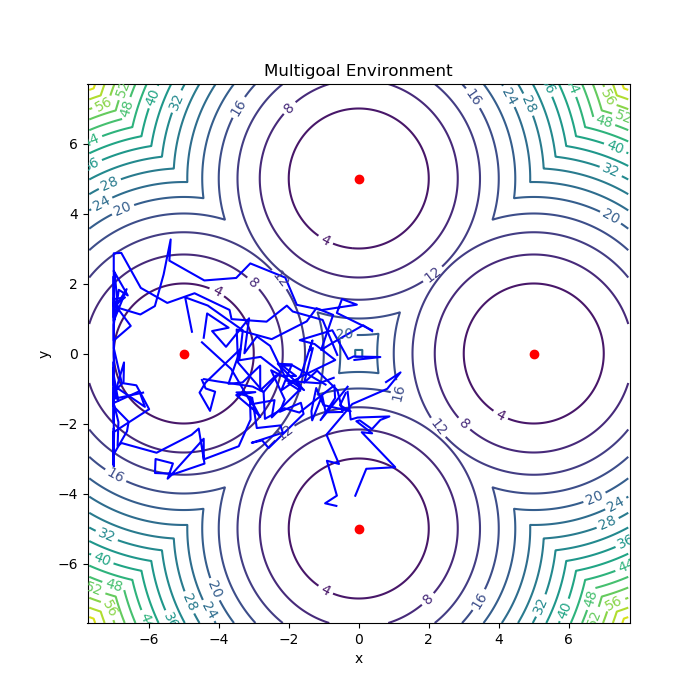

Average Reward across 10 episodes is -679.50
Reward per step of the particle is -26.03


In [17]:
agent = lambda env: torch.load('/host/final_project/model/vpg/vpg_s37/pyt_save/model.pt')
total_rewards = test_policy(agent)
print ('Average Reward across {:d} episodes is {:.2f}'.format(total_rewards[0].shape[0], np.mean(total_rewards[0])))
print ('Reward per step of the particle is {:.2f}'.format(np.mean(total_rewards[1])))

# Bayes Explore

In [12]:
%matplotlib notebook

import argparse
import sys
from tqdm import trange

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
np.set_printoptions(precision=4)

import gym
from gym import wrappers, logger

from multigoal_env.multigoal import MultiGoal

from spinup.utils.mpi_tools import mpi_fork, mpi_avg, proc_id, mpi_statistics_scalar, num_procs
from agents import RandomAgent

import torch
import tree

env_id = 'MultiGoal-v0'
seed = 1234

In [22]:
hid = 10
num_layers = 2
gamma = 0.9
num_epochs = 1000
cpu = 2

MAX_STEPS_PER_EPISODE = 100
steps = MAX_STEPS_PER_EPISODE
seed = 37

In [23]:
from algos.vpg_source.custom_actor_critic import BayesMLPActorCritic
from spinup.utils.run_utils import setup_logger_kwargs
logger_kwargs = setup_logger_kwargs('bayes_vpg', seed, data_dir='model/')
from algos.vpg_source.vpg import vpg as vpg_pytorch

In [24]:
epoch_reward = vpg_pytorch(lambda : gym.make(env_id), actor_critic=BayesMLPActorCritic,
                            ac_kwargs=dict(hidden_sizes=[hid]*num_layers), gamma=gamma, 
                            seed=seed, steps_per_epoch=steps, epochs=num_epochs,
                            logger_kwargs=logger_kwargs, max_ep_len=MAX_STEPS_PER_EPISODE)

Logging data to model/bayes_vpg/bayes_vpg_s37/progress.txt
Saving config:

{
    "ac_kwargs":	{
        "hidden_sizes":	[
            10,
            10
        ]
    },
    "actor_critic":	"BayesMLPActorCritic",
    "env_fn":	"<function <lambda> at 0x7f8bc44220e0>",
    "epochs":	1000,
    "exp_name":	"bayes_vpg",
    "gamma":	0.9,
    "lam":	0.97,
    "logger":	{
        "<spinup.utils.logx.EpochLogger object at 0x7f8bc415ec10>":	{
            "epoch_dict":	{},
            "exp_name":	"bayes_vpg",
            "first_row":	true,
            "log_current_row":	{},
            "log_headers":	[],
            "output_dir":	"model/bayes_vpg/bayes_vpg_s37",
            "output_file":	{
                "<_io.TextIOWrapper name='model/bayes_vpg/bayes_vpg_s37/progress.txt' mode='w' encoding='UTF-8'>":	{
                    "mode":	"w"
                }
            }
        }
    },
    "logger_kwargs":	{
        "exp_name":	"bayes_vpg",
        "output_dir":	"model/bayes_vpg/bayes_vpg_s37"
  

/opt/conda/lib/python3.7/site-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


---------------------------------------
|             Epoch |              10 |
|      AverageEpRet |            -889 |
|          StdEpRet |             456 |
|          MaxEpRet |            -321 |
|          MinEpRet |       -1.88e+03 |
|             EpLen |            30.6 |
|      AverageVVals |            -5.3 |
|          StdVVals |            3.37 |
|          MaxVVals |           0.396 |
|          MinVVals |           -11.1 |
| TotalEnvInteracts |         1.1e+03 |
|            LossPi |          -0.166 |
|             LossV |        5.41e+04 |
|       DeltaLossPi |               0 |
|        DeltaLossV |            -460 |
|           Entropy |           0.917 |
|                KL |        4.77e-10 |
|              Time |            7.79 |
---------------------------------------


/opt/conda/lib/python3.7/site-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


---------------------------------------
|             Epoch |              20 |
|      AverageEpRet |       -1.19e+03 |
|          StdEpRet |             815 |
|          MaxEpRet |            -320 |
|          MinEpRet |       -2.77e+03 |
|             EpLen |            41.4 |
|      AverageVVals |           -15.5 |
|          StdVVals |            2.75 |
|          MaxVVals |           -5.85 |
|          MinVVals |           -20.2 |
| TotalEnvInteracts |         2.1e+03 |
|            LossPi |          -0.158 |
|             LossV |        5.08e+04 |
|       DeltaLossPi |               0 |
|        DeltaLossV |            -418 |
|           Entropy |           0.915 |
|                KL |        3.58e-09 |
|              Time |            14.9 |
---------------------------------------


/opt/conda/lib/python3.7/site-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


---------------------------------------
|             Epoch |              30 |
|      AverageEpRet |       -1.11e+03 |
|          StdEpRet |             784 |
|          MaxEpRet |            -226 |
|          MinEpRet |       -2.84e+03 |
|             EpLen |            39.2 |
|      AverageVVals |           -24.3 |
|          StdVVals |             2.6 |
|          MaxVVals |           -19.7 |
|          MinVVals |           -29.1 |
| TotalEnvInteracts |         3.1e+03 |
|            LossPi |          -0.156 |
|             LossV |        5.04e+04 |
|       DeltaLossPi |               0 |
|        DeltaLossV |            -405 |
|           Entropy |           0.912 |
|                KL |        4.17e-10 |
|              Time |            21.8 |
---------------------------------------


/opt/conda/lib/python3.7/site-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


---------------------------------------
|             Epoch |              40 |
|      AverageEpRet |            -739 |
|          StdEpRet |             476 |
|          MaxEpRet |            -197 |
|          MinEpRet |       -2.15e+03 |
|             EpLen |            25.6 |
|      AverageVVals |           -32.6 |
|          StdVVals |            2.32 |
|          MaxVVals |           -28.4 |
|          MinVVals |           -37.2 |
| TotalEnvInteracts |         4.1e+03 |
|            LossPi |          -0.118 |
|             LossV |        3.75e+04 |
|       DeltaLossPi |               0 |
|        DeltaLossV |            -263 |
|           Entropy |            0.91 |
|                KL |        -5.6e-09 |
|              Time |            28.7 |
---------------------------------------


/opt/conda/lib/python3.7/site-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


---------------------------------------
|             Epoch |              50 |
|      AverageEpRet |            -949 |
|          StdEpRet |             678 |
|          MaxEpRet |            -212 |
|          MinEpRet |       -2.63e+03 |
|             EpLen |            35.1 |
|      AverageVVals |           -40.6 |
|          StdVVals |            2.33 |
|          MaxVVals |           -35.9 |
|          MinVVals |           -45.1 |
| TotalEnvInteracts |         5.1e+03 |
|            LossPi |          -0.144 |
|             LossV |        3.39e+04 |
|       DeltaLossPi |               0 |
|        DeltaLossV |            -310 |
|           Entropy |           0.908 |
|                KL |        1.61e-09 |
|              Time |              36 |
---------------------------------------


/opt/conda/lib/python3.7/site-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


---------------------------------------
|             Epoch |              60 |
|      AverageEpRet |       -1.19e+03 |
|          StdEpRet |             992 |
|          MaxEpRet |            -201 |
|          MinEpRet |       -3.27e+03 |
|             EpLen |              41 |
|      AverageVVals |           -49.1 |
|          StdVVals |            2.76 |
|          MaxVVals |           -44.1 |
|          MinVVals |           -54.2 |
| TotalEnvInteracts |         6.1e+03 |
|            LossPi |          -0.221 |
|             LossV |        4.43e+04 |
|       DeltaLossPi |               0 |
|        DeltaLossV |            -259 |
|           Entropy |           0.906 |
|                KL |       -1.67e-09 |
|              Time |            43.4 |
---------------------------------------


/opt/conda/lib/python3.7/site-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


---------------------------------------
|             Epoch |              70 |
|      AverageEpRet |       -1.02e+03 |
|          StdEpRet |             761 |
|          MaxEpRet |            -215 |
|          MinEpRet |       -2.83e+03 |
|             EpLen |            37.1 |
|      AverageVVals |           -57.6 |
|          StdVVals |             2.3 |
|          MaxVVals |           -53.1 |
|          MinVVals |           -61.7 |
| TotalEnvInteracts |         7.1e+03 |
|            LossPi |          -0.181 |
|             LossV |        3.24e+04 |
|       DeltaLossPi |               0 |
|        DeltaLossV |            -240 |
|           Entropy |           0.903 |
|                KL |       -1.79e-09 |
|              Time |            50.3 |
---------------------------------------


/opt/conda/lib/python3.7/site-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


---------------------------------------
|             Epoch |              80 |
|      AverageEpRet |            -801 |
|          StdEpRet |             685 |
|          MaxEpRet |            -287 |
|          MinEpRet |       -3.17e+03 |
|             EpLen |              28 |
|      AverageVVals |           -65.3 |
|          StdVVals |            2.23 |
|          MaxVVals |           -61.3 |
|          MinVVals |           -69.3 |
| TotalEnvInteracts |         8.1e+03 |
|            LossPi |         -0.0929 |
|             LossV |        2.66e+04 |
|       DeltaLossPi |               0 |
|        DeltaLossV |            -224 |
|           Entropy |           0.901 |
|                KL |       -2.44e-09 |
|              Time |            57.6 |
---------------------------------------


/opt/conda/lib/python3.7/site-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


---------------------------------------
|             Epoch |              90 |
|      AverageEpRet |            -847 |
|          StdEpRet |             506 |
|          MaxEpRet |            -241 |
|          MinEpRet |       -1.98e+03 |
|             EpLen |            31.2 |
|      AverageVVals |           -72.6 |
|          StdVVals |            2.25 |
|          MaxVVals |           -68.4 |
|          MinVVals |           -77.1 |
| TotalEnvInteracts |         9.1e+03 |
|            LossPi |          -0.157 |
|             LossV |        2.47e+04 |
|       DeltaLossPi |               0 |
|        DeltaLossV |            -227 |
|           Entropy |           0.899 |
|                KL |        4.77e-10 |
|              Time |            64.8 |
---------------------------------------


/opt/conda/lib/python3.7/site-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


---------------------------------------
|             Epoch |             100 |
|      AverageEpRet |            -724 |
|          StdEpRet |             646 |
|          MaxEpRet |            -241 |
|          MinEpRet |       -2.89e+03 |
|             EpLen |            26.3 |
|      AverageVVals |           -80.2 |
|          StdVVals |            2.22 |
|          MaxVVals |           -76.2 |
|          MinVVals |           -84.9 |
| TotalEnvInteracts |        1.01e+04 |
|            LossPi |          -0.157 |
|             LossV |        2.45e+04 |
|       DeltaLossPi |               0 |
|        DeltaLossV |            -160 |
|           Entropy |           0.897 |
|                KL |       -3.76e-09 |
|              Time |            71.9 |
---------------------------------------


/opt/conda/lib/python3.7/site-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


---------------------------------------
|             Epoch |             110 |
|      AverageEpRet |            -687 |
|          StdEpRet |             491 |
|          MaxEpRet |            -190 |
|          MinEpRet |       -2.54e+03 |
|             EpLen |            25.7 |
|      AverageVVals |             -88 |
|          StdVVals |            1.88 |
|          MaxVVals |           -84.2 |
|          MinVVals |           -92.1 |
| TotalEnvInteracts |        1.11e+04 |
|            LossPi |          -0.189 |
|             LossV |        1.75e+04 |
|       DeltaLossPi |               0 |
|        DeltaLossV |            -160 |
|           Entropy |           0.895 |
|                KL |       -1.49e-09 |
|              Time |            78.9 |
---------------------------------------


/opt/conda/lib/python3.7/site-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


---------------------------------------
|             Epoch |             120 |
|      AverageEpRet |            -855 |
|          StdEpRet |             520 |
|          MaxEpRet |            -169 |
|          MinEpRet |       -2.27e+03 |
|             EpLen |            29.9 |
|      AverageVVals |           -95.5 |
|          StdVVals |            2.45 |
|          MaxVVals |           -91.1 |
|          MinVVals |            -100 |
| TotalEnvInteracts |        1.21e+04 |
|            LossPi |           -0.13 |
|             LossV |        2.25e+04 |
|       DeltaLossPi |               0 |
|        DeltaLossV |            -267 |
|           Entropy |           0.892 |
|                KL |        4.23e-09 |
|              Time |            85.9 |
---------------------------------------


/opt/conda/lib/python3.7/site-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


---------------------------------------
|             Epoch |             130 |
|      AverageEpRet |       -1.17e+03 |
|          StdEpRet |             998 |
|          MaxEpRet |            -228 |
|          MinEpRet |       -3.22e+03 |
|             EpLen |            41.7 |
|      AverageVVals |            -104 |
|          StdVVals |            2.51 |
|          MaxVVals |           -99.2 |
|          MinVVals |            -109 |
| TotalEnvInteracts |        1.31e+04 |
|            LossPi |          -0.161 |
|             LossV |        2.28e+04 |
|       DeltaLossPi |               0 |
|        DeltaLossV |            -224 |
|           Entropy |            0.89 |
|                KL |        2.26e-09 |
|              Time |            92.9 |
---------------------------------------


/opt/conda/lib/python3.7/site-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


---------------------------------------
|             Epoch |             140 |
|      AverageEpRet |            -912 |
|          StdEpRet |             646 |
|          MaxEpRet |            -252 |
|          MinEpRet |       -2.94e+03 |
|             EpLen |            33.2 |
|      AverageVVals |            -112 |
|          StdVVals |            2.18 |
|          MaxVVals |            -108 |
|          MinVVals |            -117 |
| TotalEnvInteracts |        1.41e+04 |
|            LossPi |          -0.112 |
|             LossV |        1.68e+04 |
|       DeltaLossPi |               0 |
|        DeltaLossV |            -127 |
|           Entropy |           0.888 |
|                KL |        1.19e-09 |
|              Time |            99.8 |
---------------------------------------


/opt/conda/lib/python3.7/site-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


---------------------------------------
|             Epoch |             150 |
|      AverageEpRet |            -748 |
|          StdEpRet |             591 |
|          MaxEpRet |            -277 |
|          MinEpRet |        -2.5e+03 |
|             EpLen |            27.9 |
|      AverageVVals |            -119 |
|          StdVVals |            1.75 |
|          MaxVVals |            -115 |
|          MinVVals |            -122 |
| TotalEnvInteracts |        1.51e+04 |
|            LossPi |          -0.188 |
|             LossV |        1.39e+04 |
|       DeltaLossPi |               0 |
|        DeltaLossV |           -91.3 |
|           Entropy |           0.886 |
|                KL |       -3.04e-09 |
|              Time |             107 |
---------------------------------------


/opt/conda/lib/python3.7/site-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


---------------------------------------
|             Epoch |             160 |
|      AverageEpRet |            -751 |
|          StdEpRet |             575 |
|          MaxEpRet |            -242 |
|          MinEpRet |       -2.51e+03 |
|             EpLen |            26.3 |
|      AverageVVals |            -126 |
|          StdVVals |             2.1 |
|          MaxVVals |            -108 |
|          MinVVals |            -130 |
| TotalEnvInteracts |        1.61e+04 |
|            LossPi |          -0.139 |
|             LossV |        1.85e+04 |
|       DeltaLossPi |               0 |
|        DeltaLossV |            -165 |
|           Entropy |           0.884 |
|                KL |        3.04e-09 |
|              Time |             114 |
---------------------------------------


/opt/conda/lib/python3.7/site-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


---------------------------------------
|             Epoch |             170 |
|      AverageEpRet |            -727 |
|          StdEpRet |             603 |
|          MaxEpRet |            -159 |
|          MinEpRet |       -2.45e+03 |
|             EpLen |            26.2 |
|      AverageVVals |            -133 |
|          StdVVals |            1.96 |
|          MaxVVals |            -129 |
|          MinVVals |            -137 |
| TotalEnvInteracts |        1.71e+04 |
|            LossPi |          -0.178 |
|             LossV |        1.28e+04 |
|       DeltaLossPi |               0 |
|        DeltaLossV |           -57.6 |
|           Entropy |           0.882 |
|                KL |       -4.05e-09 |
|              Time |             121 |
---------------------------------------


/opt/conda/lib/python3.7/site-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


---------------------------------------
|             Epoch |             180 |
|      AverageEpRet |            -790 |
|          StdEpRet |             703 |
|          MaxEpRet |            -225 |
|          MinEpRet |        -3.4e+03 |
|             EpLen |            28.1 |
|      AverageVVals |            -140 |
|          StdVVals |            2.26 |
|          MaxVVals |            -136 |
|          MinVVals |            -144 |
| TotalEnvInteracts |        1.81e+04 |
|            LossPi |          -0.128 |
|             LossV |        1.48e+04 |
|       DeltaLossPi |               0 |
|        DeltaLossV |            -144 |
|           Entropy |           0.879 |
|                KL |        4.59e-09 |
|              Time |             128 |
---------------------------------------


/opt/conda/lib/python3.7/site-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


---------------------------------------
|             Epoch |             190 |
|      AverageEpRet |            -603 |
|          StdEpRet |             392 |
|          MaxEpRet |            -184 |
|          MinEpRet |       -1.66e+03 |
|             EpLen |            21.2 |
|      AverageVVals |            -145 |
|          StdVVals |            8.88 |
|          MaxVVals |            36.7 |
|          MinVVals |            -150 |
| TotalEnvInteracts |        1.91e+04 |
|            LossPi |          -0.153 |
|             LossV |         1.1e+04 |
|       DeltaLossPi |               0 |
|        DeltaLossV |            -135 |
|           Entropy |           0.877 |
|                KL |       -1.79e-10 |
|              Time |             136 |
---------------------------------------


/opt/conda/lib/python3.7/site-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


---------------------------------------
|             Epoch |             200 |
|      AverageEpRet |       -1.05e+03 |
|          StdEpRet |             868 |
|          MaxEpRet |            -212 |
|          MinEpRet |       -3.22e+03 |
|             EpLen |              38 |
|      AverageVVals |            -153 |
|          StdVVals |            2.28 |
|          MaxVVals |            -148 |
|          MinVVals |            -157 |
| TotalEnvInteracts |        2.01e+04 |
|            LossPi |          -0.184 |
|             LossV |        1.41e+04 |
|       DeltaLossPi |               0 |
|        DeltaLossV |            -165 |
|           Entropy |           0.875 |
|                KL |        1.91e-09 |
|              Time |             143 |
---------------------------------------


/opt/conda/lib/python3.7/site-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


---------------------------------------
|             Epoch |             210 |
|      AverageEpRet |            -818 |
|          StdEpRet |             633 |
|          MaxEpRet |            -180 |
|          MinEpRet |       -2.93e+03 |
|             EpLen |              29 |
|      AverageVVals |            -160 |
|          StdVVals |            1.84 |
|          MaxVVals |            -157 |
|          MinVVals |            -164 |
| TotalEnvInteracts |        2.11e+04 |
|            LossPi |          -0.123 |
|             LossV |        1.12e+04 |
|       DeltaLossPi |               0 |
|        DeltaLossV |           -81.7 |
|           Entropy |           0.872 |
|                KL |       -1.25e-09 |
|              Time |             150 |
---------------------------------------


/opt/conda/lib/python3.7/site-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


---------------------------------------
|             Epoch |             220 |
|      AverageEpRet |            -575 |
|          StdEpRet |             308 |
|          MaxEpRet |            -173 |
|          MinEpRet |        -1.4e+03 |
|             EpLen |            21.1 |
|      AverageVVals |            -164 |
|          StdVVals |           0.711 |
|          MaxVVals |            -163 |
|          MinVVals |            -167 |
| TotalEnvInteracts |        2.21e+04 |
|            LossPi |           -0.16 |
|             LossV |        8.46e+03 |
|       DeltaLossPi |               0 |
|        DeltaLossV |             -30 |
|           Entropy |            0.87 |
|                KL |        5.36e-10 |
|              Time |             157 |
---------------------------------------


/opt/conda/lib/python3.7/site-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


---------------------------------------
|             Epoch |             230 |
|      AverageEpRet |            -507 |
|          StdEpRet |             287 |
|          MaxEpRet |            -175 |
|          MinEpRet |       -1.19e+03 |
|             EpLen |            18.6 |
|      AverageVVals |            -169 |
|          StdVVals |             2.1 |
|          MaxVVals |            -166 |
|          MinVVals |            -173 |
| TotalEnvInteracts |        2.31e+04 |
|            LossPi |           -0.12 |
|             LossV |        1.38e+04 |
|       DeltaLossPi |               0 |
|        DeltaLossV |            -123 |
|           Entropy |           0.868 |
|                KL |        4.47e-09 |
|              Time |             164 |
---------------------------------------


/opt/conda/lib/python3.7/site-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


---------------------------------------
|             Epoch |             240 |
|      AverageEpRet |            -631 |
|          StdEpRet |             529 |
|          MaxEpRet |            -215 |
|          MinEpRet |       -3.12e+03 |
|             EpLen |            23.5 |
|      AverageVVals |            -174 |
|          StdVVals |            1.23 |
|          MaxVVals |            -171 |
|          MinVVals |            -176 |
| TotalEnvInteracts |        2.41e+04 |
|            LossPi |          -0.151 |
|             LossV |        9.96e+03 |
|       DeltaLossPi |               0 |
|        DeltaLossV |           -46.1 |
|           Entropy |           0.866 |
|                KL |       -2.03e-09 |
|              Time |             171 |
---------------------------------------


/opt/conda/lib/python3.7/site-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


---------------------------------------
|             Epoch |             250 |
|      AverageEpRet |            -604 |
|          StdEpRet |             559 |
|          MaxEpRet |            -210 |
|          MinEpRet |       -3.09e+03 |
|             EpLen |            21.1 |
|      AverageVVals |            -153 |
|          StdVVals |            63.8 |
|          MaxVVals |             122 |
|          MinVVals |            -178 |
| TotalEnvInteracts |        2.51e+04 |
|            LossPi |         -0.0925 |
|             LossV |         2.1e+04 |
|       DeltaLossPi |               0 |
|        DeltaLossV |       -9.48e+03 |
|           Entropy |           0.864 |
|                KL |        1.01e-09 |
|              Time |             179 |
---------------------------------------


/opt/conda/lib/python3.7/site-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


---------------------------------------
|             Epoch |             260 |
|      AverageEpRet |            -798 |
|          StdEpRet |             821 |
|          MaxEpRet |            -165 |
|          MinEpRet |       -3.04e+03 |
|             EpLen |            29.7 |
|      AverageVVals |            -172 |
|          StdVVals |            5.11 |
|          MaxVVals |            -155 |
|          MinVVals |            -180 |
| TotalEnvInteracts |        2.61e+04 |
|            LossPi |          -0.191 |
|             LossV |        9.02e+03 |
|       DeltaLossPi |               0 |
|        DeltaLossV |            -235 |
|           Entropy |           0.862 |
|                KL |        2.15e-09 |
|              Time |             186 |
---------------------------------------


/opt/conda/lib/python3.7/site-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


---------------------------------------
|             Epoch |             270 |
|      AverageEpRet |            -600 |
|          StdEpRet |             596 |
|          MaxEpRet |            -159 |
|          MinEpRet |       -3.23e+03 |
|             EpLen |            21.8 |
|      AverageVVals |            -180 |
|          StdVVals |            1.43 |
|          MaxVVals |            -174 |
|          MinVVals |            -184 |
| TotalEnvInteracts |        2.71e+04 |
|            LossPi |           -0.15 |
|             LossV |        1.03e+04 |
|       DeltaLossPi |               0 |
|        DeltaLossV |           -95.1 |
|           Entropy |            0.86 |
|                KL |       -4.77e-10 |
|              Time |             193 |
---------------------------------------


/opt/conda/lib/python3.7/site-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


---------------------------------------
|             Epoch |             280 |
|      AverageEpRet |            -721 |
|          StdEpRet |             526 |
|          MaxEpRet |            -157 |
|          MinEpRet |       -2.54e+03 |
|             EpLen |            28.3 |
|      AverageVVals |            -182 |
|          StdVVals |           0.948 |
|          MaxVVals |            -178 |
|          MinVVals |            -184 |
| TotalEnvInteracts |        2.81e+04 |
|            LossPi |          -0.152 |
|             LossV |        7.95e+03 |
|       DeltaLossPi |               0 |
|        DeltaLossV |           -21.9 |
|           Entropy |           0.858 |
|                KL |        3.28e-09 |
|              Time |             201 |
---------------------------------------


/opt/conda/lib/python3.7/site-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


---------------------------------------
|             Epoch |             290 |
|      AverageEpRet |            -464 |
|          StdEpRet |             247 |
|          MaxEpRet |            -196 |
|          MinEpRet |        -1.3e+03 |
|             EpLen |            16.9 |
|      AverageVVals |            -179 |
|          StdVVals |            2.26 |
|          MaxVVals |            -171 |
|          MinVVals |            -183 |
| TotalEnvInteracts |        2.91e+04 |
|            LossPi |           -0.11 |
|             LossV |        8.06e+03 |
|       DeltaLossPi |               0 |
|        DeltaLossV |           -39.5 |
|           Entropy |           0.856 |
|                KL |       -2.92e-09 |
|              Time |             210 |
---------------------------------------


/opt/conda/lib/python3.7/site-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


---------------------------------------
|             Epoch |             300 |
|      AverageEpRet |            -695 |
|          StdEpRet |             658 |
|          MaxEpRet |            -190 |
|          MinEpRet |       -2.88e+03 |
|             EpLen |            25.7 |
|      AverageVVals |            -182 |
|          StdVVals |            3.13 |
|          MaxVVals |            -172 |
|          MinVVals |            -186 |
| TotalEnvInteracts |        3.01e+04 |
|            LossPi |          -0.188 |
|             LossV |        1.07e+04 |
|       DeltaLossPi |               0 |
|        DeltaLossV |            -122 |
|           Entropy |           0.854 |
|                KL |        3.81e-09 |
|              Time |             219 |
---------------------------------------


/opt/conda/lib/python3.7/site-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


---------------------------------------
|             Epoch |             310 |
|      AverageEpRet |            -680 |
|          StdEpRet |             665 |
|          MaxEpRet |            -224 |
|          MinEpRet |       -2.98e+03 |
|             EpLen |            25.9 |
|      AverageVVals |            -185 |
|          StdVVals |            1.41 |
|          MaxVVals |            -182 |
|          MinVVals |            -188 |
| TotalEnvInteracts |        3.11e+04 |
|            LossPi |          -0.151 |
|             LossV |         8.7e+03 |
|       DeltaLossPi |               0 |
|        DeltaLossV |           -88.5 |
|           Entropy |           0.851 |
|                KL |        1.79e-10 |
|              Time |             228 |
---------------------------------------


/opt/conda/lib/python3.7/site-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


---------------------------------------
|             Epoch |             320 |
|      AverageEpRet |            -880 |
|          StdEpRet |             806 |
|          MaxEpRet |            -242 |
|          MinEpRet |        -2.9e+03 |
|             EpLen |            33.8 |
|      AverageVVals |            -186 |
|          StdVVals |            0.83 |
|          MaxVVals |            -182 |
|          MinVVals |            -188 |
| TotalEnvInteracts |        3.21e+04 |
|            LossPi |          -0.185 |
|             LossV |        9.34e+03 |
|       DeltaLossPi |               0 |
|        DeltaLossV |           -72.4 |
|           Entropy |           0.849 |
|                KL |        3.22e-09 |
|              Time |             237 |
---------------------------------------


/opt/conda/lib/python3.7/site-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


---------------------------------------
|             Epoch |             330 |
|      AverageEpRet |            -633 |
|          StdEpRet |             506 |
|          MaxEpRet |            -252 |
|          MinEpRet |          -3e+03 |
|             EpLen |              23 |
|      AverageVVals |            -188 |
|          StdVVals |            0.56 |
|          MaxVVals |            -186 |
|          MinVVals |            -190 |
| TotalEnvInteracts |        3.31e+04 |
|            LossPi |          -0.146 |
|             LossV |        9.01e+03 |
|       DeltaLossPi |               0 |
|        DeltaLossV |           -35.6 |
|           Entropy |           0.846 |
|                KL |        2.68e-09 |
|              Time |             246 |
---------------------------------------


/opt/conda/lib/python3.7/site-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


---------------------------------------
|             Epoch |             340 |
|      AverageEpRet |            -499 |
|          StdEpRet |             212 |
|          MaxEpRet |            -211 |
|          MinEpRet |       -1.13e+03 |
|             EpLen |            18.5 |
|      AverageVVals |            -185 |
|          StdVVals |            2.42 |
|          MaxVVals |            -168 |
|          MinVVals |            -189 |
| TotalEnvInteracts |        3.41e+04 |
|            LossPi |          -0.131 |
|             LossV |        8.54e+03 |
|       DeltaLossPi |               0 |
|        DeltaLossV |           -77.6 |
|           Entropy |           0.844 |
|                KL |       -1.01e-09 |
|              Time |             255 |
---------------------------------------


/opt/conda/lib/python3.7/site-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


---------------------------------------
|             Epoch |             350 |
|      AverageEpRet |            -511 |
|          StdEpRet |             360 |
|          MaxEpRet |            -204 |
|          MinEpRet |       -1.82e+03 |
|             EpLen |            19.5 |
|      AverageVVals |            -184 |
|          StdVVals |            1.42 |
|          MaxVVals |            -180 |
|          MinVVals |            -187 |
| TotalEnvInteracts |        3.51e+04 |
|            LossPi |          -0.201 |
|             LossV |        9.14e+03 |
|       DeltaLossPi |               0 |
|        DeltaLossV |           -83.2 |
|           Entropy |           0.842 |
|                KL |       -8.34e-10 |
|              Time |             264 |
---------------------------------------


/opt/conda/lib/python3.7/site-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


---------------------------------------
|             Epoch |             360 |
|      AverageEpRet |            -576 |
|          StdEpRet |             469 |
|          MaxEpRet |            -206 |
|          MinEpRet |       -2.31e+03 |
|             EpLen |            21.2 |
|      AverageVVals |            -185 |
|          StdVVals |           0.762 |
|          MaxVVals |            -183 |
|          MinVVals |            -187 |
| TotalEnvInteracts |        3.61e+04 |
|            LossPi |           -0.15 |
|             LossV |        8.21e+03 |
|       DeltaLossPi |               0 |
|        DeltaLossV |           -59.5 |
|           Entropy |           0.839 |
|                KL |       -1.25e-09 |
|              Time |             272 |
---------------------------------------


/opt/conda/lib/python3.7/site-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


---------------------------------------
|             Epoch |             370 |
|      AverageEpRet |            -484 |
|          StdEpRet |             263 |
|          MaxEpRet |            -189 |
|          MinEpRet |       -1.23e+03 |
|             EpLen |            17.8 |
|      AverageVVals |            -184 |
|          StdVVals |            0.81 |
|          MaxVVals |            -181 |
|          MinVVals |            -186 |
| TotalEnvInteracts |        3.71e+04 |
|            LossPi |          -0.092 |
|             LossV |        8.25e+03 |
|       DeltaLossPi |               0 |
|        DeltaLossV |           -81.2 |
|           Entropy |           0.837 |
|                KL |        1.31e-09 |
|              Time |             281 |
---------------------------------------


/opt/conda/lib/python3.7/site-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


---------------------------------------
|             Epoch |             380 |
|      AverageEpRet |            -508 |
|          StdEpRet |             306 |
|          MaxEpRet |            -145 |
|          MinEpRet |       -1.53e+03 |
|             EpLen |            19.6 |
|      AverageVVals |            -167 |
|          StdVVals |            43.4 |
|          MaxVVals |             117 |
|          MinVVals |            -185 |
| TotalEnvInteracts |        3.81e+04 |
|            LossPi |          -0.186 |
|             LossV |        8.07e+03 |
|       DeltaLossPi |               0 |
|        DeltaLossV |       -1.11e+03 |
|           Entropy |           0.835 |
|                KL |       -3.46e-09 |
|              Time |             290 |
---------------------------------------


/opt/conda/lib/python3.7/site-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


---------------------------------------
|             Epoch |             390 |
|      AverageEpRet |            -519 |
|          StdEpRet |             372 |
|          MaxEpRet |            -180 |
|          MinEpRet |       -2.36e+03 |
|             EpLen |            19.5 |
|      AverageVVals |            -177 |
|          StdVVals |            14.1 |
|          MaxVVals |           -44.5 |
|          MinVVals |            -183 |
| TotalEnvInteracts |        3.91e+04 |
|            LossPi |          -0.177 |
|             LossV |        8.95e+03 |
|       DeltaLossPi |               0 |
|        DeltaLossV |            -508 |
|           Entropy |           0.833 |
|                KL |        3.16e-09 |
|              Time |             299 |
---------------------------------------


/opt/conda/lib/python3.7/site-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


---------------------------------------
|             Epoch |             400 |
|      AverageEpRet |            -516 |
|          StdEpRet |             348 |
|          MaxEpRet |            -211 |
|          MinEpRet |       -1.87e+03 |
|             EpLen |            19.5 |
|      AverageVVals |            -164 |
|          StdVVals |            39.7 |
|          MaxVVals |            73.9 |
|          MinVVals |            -179 |
| TotalEnvInteracts |        4.01e+04 |
|            LossPi |          -0.134 |
|             LossV |        9.62e+03 |
|       DeltaLossPi |               0 |
|        DeltaLossV |        -2.3e+03 |
|           Entropy |            0.83 |
|                KL |        1.79e-09 |
|              Time |             308 |
---------------------------------------


/opt/conda/lib/python3.7/site-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


---------------------------------------
|             Epoch |             410 |
|      AverageEpRet |            -455 |
|          StdEpRet |             261 |
|          MaxEpRet |            -147 |
|          MinEpRet |       -1.58e+03 |
|             EpLen |            17.5 |
|      AverageVVals |            -149 |
|          StdVVals |            51.5 |
|          MaxVVals |            88.2 |
|          MinVVals |            -180 |
| TotalEnvInteracts |        4.11e+04 |
|            LossPi |         -0.0977 |
|             LossV |        9.93e+03 |
|       DeltaLossPi |               0 |
|        DeltaLossV |       -3.18e+03 |
|           Entropy |           0.828 |
|                KL |        2.15e-09 |
|              Time |             317 |
---------------------------------------


/opt/conda/lib/python3.7/site-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


---------------------------------------
|             Epoch |             420 |
|      AverageEpRet |            -762 |
|          StdEpRet |             769 |
|          MaxEpRet |            -205 |
|          MinEpRet |       -3.01e+03 |
|             EpLen |            28.6 |
|      AverageVVals |            -172 |
|          StdVVals |            15.9 |
|          MaxVVals |           -76.9 |
|          MinVVals |            -183 |
| TotalEnvInteracts |        4.21e+04 |
|            LossPi |          -0.115 |
|             LossV |        9.39e+03 |
|       DeltaLossPi |               0 |
|        DeltaLossV |            -991 |
|           Entropy |           0.827 |
|                KL |       -1.97e-09 |
|              Time |             326 |
---------------------------------------


/opt/conda/lib/python3.7/site-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


---------------------------------------
|             Epoch |             430 |
|      AverageEpRet |            -540 |
|          StdEpRet |             482 |
|          MaxEpRet |            -202 |
|          MinEpRet |       -2.75e+03 |
|             EpLen |            19.9 |
|      AverageVVals |            -182 |
|          StdVVals |            1.22 |
|          MaxVVals |            -178 |
|          MinVVals |            -184 |
| TotalEnvInteracts |        4.31e+04 |
|            LossPi |          -0.157 |
|             LossV |        9.21e+03 |
|       DeltaLossPi |               0 |
|        DeltaLossV |           -78.6 |
|           Entropy |           0.825 |
|                KL |       -1.43e-09 |
|              Time |             334 |
---------------------------------------


/opt/conda/lib/python3.7/site-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


---------------------------------------
|             Epoch |             440 |
|      AverageEpRet |            -606 |
|          StdEpRet |             536 |
|          MaxEpRet |            -203 |
|          MinEpRet |        -2.8e+03 |
|             EpLen |            23.3 |
|      AverageVVals |            -180 |
|          StdVVals |            4.13 |
|          MaxVVals |            -150 |
|          MinVVals |            -183 |
| TotalEnvInteracts |        4.41e+04 |
|            LossPi |          -0.154 |
|             LossV |        8.34e+03 |
|       DeltaLossPi |               0 |
|        DeltaLossV |            -292 |
|           Entropy |           0.823 |
|                KL |       -5.96e-11 |
|              Time |             341 |
---------------------------------------


/opt/conda/lib/python3.7/site-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


---------------------------------------
|             Epoch |             450 |
|      AverageEpRet |            -592 |
|          StdEpRet |             650 |
|          MaxEpRet |            -238 |
|          MinEpRet |       -3.34e+03 |
|             EpLen |            21.5 |
|      AverageVVals |            -181 |
|          StdVVals |            2.84 |
|          MaxVVals |            -166 |
|          MinVVals |            -184 |
| TotalEnvInteracts |        4.51e+04 |
|            LossPi |          -0.139 |
|             LossV |        9.03e+03 |
|       DeltaLossPi |               0 |
|        DeltaLossV |            -196 |
|           Entropy |           0.821 |
|                KL |       -2.03e-09 |
|              Time |             348 |
---------------------------------------


/opt/conda/lib/python3.7/site-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


---------------------------------------
|             Epoch |             460 |
|      AverageEpRet |            -636 |
|          StdEpRet |             612 |
|          MaxEpRet |            -210 |
|          MinEpRet |       -2.72e+03 |
|             EpLen |            24.7 |
|      AverageVVals |            -182 |
|          StdVVals |            1.05 |
|          MaxVVals |            -179 |
|          MinVVals |            -184 |
| TotalEnvInteracts |        4.61e+04 |
|            LossPi |          -0.107 |
|             LossV |        7.92e+03 |
|       DeltaLossPi |               0 |
|        DeltaLossV |           -86.5 |
|           Entropy |           0.818 |
|                KL |       -2.98e-10 |
|              Time |             355 |
---------------------------------------


/opt/conda/lib/python3.7/site-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


---------------------------------------
|             Epoch |             470 |
|      AverageEpRet |            -434 |
|          StdEpRet |             257 |
|          MaxEpRet |            -152 |
|          MinEpRet |       -1.55e+03 |
|             EpLen |            16.7 |
|      AverageVVals |            -178 |
|          StdVVals |            1.43 |
|          MaxVVals |            -176 |
|          MinVVals |            -182 |
| TotalEnvInteracts |        4.71e+04 |
|            LossPi |          -0.142 |
|             LossV |        8.87e+03 |
|       DeltaLossPi |               0 |
|        DeltaLossV |           -74.4 |
|           Entropy |           0.817 |
|                KL |       -1.13e-09 |
|              Time |             363 |
---------------------------------------


/opt/conda/lib/python3.7/site-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


---------------------------------------
|             Epoch |             480 |
|      AverageEpRet |            -496 |
|          StdEpRet |             429 |
|          MaxEpRet |            -163 |
|          MinEpRet |       -2.21e+03 |
|             EpLen |            19.2 |
|      AverageVVals |            -159 |
|          StdVVals |            40.3 |
|          MaxVVals |            27.6 |
|          MinVVals |            -178 |
| TotalEnvInteracts |        4.81e+04 |
|            LossPi |          -0.172 |
|             LossV |        2.24e+04 |
|       DeltaLossPi |               0 |
|        DeltaLossV |       -7.65e+03 |
|           Entropy |           0.815 |
|                KL |       -1.25e-09 |
|              Time |             370 |
---------------------------------------


/opt/conda/lib/python3.7/site-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


---------------------------------------
|             Epoch |             490 |
|      AverageEpRet |            -542 |
|          StdEpRet |             493 |
|          MaxEpRet |            -156 |
|          MinEpRet |       -2.11e+03 |
|             EpLen |              21 |
|      AverageVVals |            -170 |
|          StdVVals |            14.1 |
|          MaxVVals |           -94.1 |
|          MinVVals |            -178 |
| TotalEnvInteracts |        4.91e+04 |
|            LossPi |          -0.206 |
|             LossV |        8.34e+03 |
|       DeltaLossPi |               0 |
|        DeltaLossV |            -527 |
|           Entropy |           0.812 |
|                KL |       -8.34e-10 |
|              Time |             377 |
---------------------------------------


/opt/conda/lib/python3.7/site-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


---------------------------------------
|             Epoch |             500 |
|      AverageEpRet |            -428 |
|          StdEpRet |             192 |
|          MaxEpRet |            -194 |
|          MinEpRet |       -1.05e+03 |
|             EpLen |            15.6 |
|      AverageVVals |            -172 |
|          StdVVals |            7.03 |
|          MaxVVals |            -136 |
|          MinVVals |            -178 |
| TotalEnvInteracts |        5.01e+04 |
|            LossPi |          -0.174 |
|             LossV |        8.27e+03 |
|       DeltaLossPi |               0 |
|        DeltaLossV |            -283 |
|           Entropy |            0.81 |
|                KL |        3.04e-09 |
|              Time |             384 |
---------------------------------------


/opt/conda/lib/python3.7/site-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


---------------------------------------
|             Epoch |             510 |
|      AverageEpRet |            -429 |
|          StdEpRet |             425 |
|          MaxEpRet |            -175 |
|          MinEpRet |       -2.96e+03 |
|             EpLen |            15.9 |
|      AverageVVals |            -173 |
|          StdVVals |            2.28 |
|          MaxVVals |            -163 |
|          MinVVals |            -177 |
| TotalEnvInteracts |        5.11e+04 |
|            LossPi |          -0.132 |
|             LossV |        9.53e+03 |
|       DeltaLossPi |               0 |
|        DeltaLossV |            -204 |
|           Entropy |           0.807 |
|                KL |       -8.34e-10 |
|              Time |             391 |
---------------------------------------


/opt/conda/lib/python3.7/site-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


---------------------------------------
|             Epoch |             520 |
|      AverageEpRet |            -449 |
|          StdEpRet |             277 |
|          MaxEpRet |            -171 |
|          MinEpRet |       -1.45e+03 |
|             EpLen |            17.4 |
|      AverageVVals |            -174 |
|          StdVVals |            1.38 |
|          MaxVVals |            -168 |
|          MinVVals |            -177 |
| TotalEnvInteracts |        5.21e+04 |
|            LossPi |           -0.17 |
|             LossV |        7.29e+03 |
|       DeltaLossPi |               0 |
|        DeltaLossV |           -44.9 |
|           Entropy |           0.805 |
|                KL |        1.43e-09 |
|              Time |             398 |
---------------------------------------


/opt/conda/lib/python3.7/site-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


---------------------------------------
|             Epoch |             530 |
|      AverageEpRet |            -539 |
|          StdEpRet |             471 |
|          MaxEpRet |            -199 |
|          MinEpRet |        -2.9e+03 |
|             EpLen |            20.2 |
|      AverageVVals |            -174 |
|          StdVVals |               2 |
|          MaxVVals |            -168 |
|          MinVVals |            -178 |
| TotalEnvInteracts |        5.31e+04 |
|            LossPi |          -0.177 |
|             LossV |        7.41e+03 |
|       DeltaLossPi |               0 |
|        DeltaLossV |            -114 |
|           Entropy |           0.802 |
|                KL |       -2.98e-09 |
|              Time |             405 |
---------------------------------------


/opt/conda/lib/python3.7/site-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


---------------------------------------
|             Epoch |             540 |
|      AverageEpRet |            -488 |
|          StdEpRet |             267 |
|          MaxEpRet |            -199 |
|          MinEpRet |       -1.29e+03 |
|             EpLen |            19.4 |
|      AverageVVals |            -145 |
|          StdVVals |              52 |
|          MaxVVals |            36.2 |
|          MinVVals |            -175 |
| TotalEnvInteracts |        5.41e+04 |
|            LossPi |          -0.204 |
|             LossV |        8.81e+03 |
|       DeltaLossPi |               0 |
|        DeltaLossV |       -2.83e+03 |
|           Entropy |             0.8 |
|                KL |        2.09e-09 |
|              Time |             412 |
---------------------------------------


/opt/conda/lib/python3.7/site-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


---------------------------------------
|             Epoch |             550 |
|      AverageEpRet |            -439 |
|          StdEpRet |             385 |
|          MaxEpRet |            -217 |
|          MinEpRet |       -2.95e+03 |
|             EpLen |            16.8 |
|      AverageVVals |            -161 |
|          StdVVals |            27.8 |
|          MaxVVals |           -22.5 |
|          MinVVals |            -178 |
| TotalEnvInteracts |        5.51e+04 |
|            LossPi |          -0.165 |
|             LossV |        8.92e+03 |
|       DeltaLossPi |               0 |
|        DeltaLossV |       -1.28e+03 |
|           Entropy |           0.797 |
|                KL |        5.13e-09 |
|              Time |             420 |
---------------------------------------


/opt/conda/lib/python3.7/site-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


---------------------------------------
|             Epoch |             560 |
|      AverageEpRet |            -463 |
|          StdEpRet |             329 |
|          MaxEpRet |            -163 |
|          MinEpRet |       -1.89e+03 |
|             EpLen |            18.2 |
|      AverageVVals |            -150 |
|          StdVVals |            31.2 |
|          MaxVVals |           -15.2 |
|          MinVVals |            -173 |
| TotalEnvInteracts |        5.61e+04 |
|            LossPi |          -0.173 |
|             LossV |        6.88e+03 |
|       DeltaLossPi |               0 |
|        DeltaLossV |            -689 |
|           Entropy |           0.795 |
|                KL |       -2.32e-09 |
|              Time |             427 |
---------------------------------------


/opt/conda/lib/python3.7/site-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


---------------------------------------
|             Epoch |             570 |
|      AverageEpRet |            -552 |
|          StdEpRet |             407 |
|          MaxEpRet |            -208 |
|          MinEpRet |       -1.97e+03 |
|             EpLen |            21.8 |
|      AverageVVals |            -146 |
|          StdVVals |            47.5 |
|          MaxVVals |            29.7 |
|          MinVVals |            -173 |
| TotalEnvInteracts |        5.71e+04 |
|            LossPi |          -0.146 |
|             LossV |        9.05e+03 |
|       DeltaLossPi |               0 |
|        DeltaLossV |       -2.53e+03 |
|           Entropy |           0.792 |
|                KL |       -5.96e-11 |
|              Time |             434 |
---------------------------------------


/opt/conda/lib/python3.7/site-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


---------------------------------------
|             Epoch |             580 |
|      AverageEpRet |            -427 |
|          StdEpRet |             258 |
|          MaxEpRet |            -161 |
|          MinEpRet |       -1.31e+03 |
|             EpLen |            16.7 |
|      AverageVVals |            -151 |
|          StdVVals |              30 |
|          MaxVVals |            6.82 |
|          MinVVals |            -174 |
| TotalEnvInteracts |        5.81e+04 |
|            LossPi |          -0.195 |
|             LossV |        7.92e+03 |
|       DeltaLossPi |               0 |
|        DeltaLossV |       -1.36e+03 |
|           Entropy |            0.79 |
|                KL |       -1.25e-09 |
|              Time |             443 |
---------------------------------------


/opt/conda/lib/python3.7/site-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


---------------------------------------
|             Epoch |             590 |
|      AverageEpRet |            -625 |
|          StdEpRet |             615 |
|          MaxEpRet |            -161 |
|          MinEpRet |       -2.52e+03 |
|             EpLen |            24.3 |
|      AverageVVals |            -154 |
|          StdVVals |            28.4 |
|          MaxVVals |           -15.1 |
|          MinVVals |            -178 |
| TotalEnvInteracts |        5.91e+04 |
|            LossPi |          -0.208 |
|             LossV |        7.28e+03 |
|       DeltaLossPi |               0 |
|        DeltaLossV |        -1.4e+03 |
|           Entropy |           0.787 |
|                KL |       -1.07e-09 |
|              Time |             450 |
---------------------------------------


/opt/conda/lib/python3.7/site-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


---------------------------------------
|             Epoch |             600 |
|      AverageEpRet |            -463 |
|          StdEpRet |             287 |
|          MaxEpRet |            -161 |
|          MinEpRet |       -1.42e+03 |
|             EpLen |            18.2 |
|      AverageVVals |            -175 |
|          StdVVals |            7.12 |
|          MaxVVals |            -122 |
|          MinVVals |            -180 |
| TotalEnvInteracts |        6.01e+04 |
|            LossPi |          -0.166 |
|             LossV |        7.09e+03 |
|       DeltaLossPi |               0 |
|        DeltaLossV |            -344 |
|           Entropy |           0.784 |
|                KL |        4.71e-09 |
|              Time |             458 |
---------------------------------------


/opt/conda/lib/python3.7/site-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


---------------------------------------
|             Epoch |             610 |
|      AverageEpRet |            -470 |
|          StdEpRet |             363 |
|          MaxEpRet |            -182 |
|          MinEpRet |       -1.86e+03 |
|             EpLen |            19.2 |
|      AverageVVals |            -165 |
|          StdVVals |            17.1 |
|          MaxVVals |            -102 |
|          MinVVals |            -178 |
| TotalEnvInteracts |        6.11e+04 |
|            LossPi |          -0.148 |
|             LossV |        7.61e+03 |
|       DeltaLossPi |               0 |
|        DeltaLossV |            -699 |
|           Entropy |           0.782 |
|                KL |       -1.91e-09 |
|              Time |             465 |
---------------------------------------


/opt/conda/lib/python3.7/site-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


---------------------------------------
|             Epoch |             620 |
|      AverageEpRet |            -486 |
|          StdEpRet |             393 |
|          MaxEpRet |            -163 |
|          MinEpRet |       -2.53e+03 |
|             EpLen |            19.7 |
|      AverageVVals |            -148 |
|          StdVVals |            31.5 |
|          MaxVVals |           -25.5 |
|          MinVVals |            -174 |
| TotalEnvInteracts |        6.21e+04 |
|            LossPi |          -0.172 |
|             LossV |        7.47e+03 |
|       DeltaLossPi |               0 |
|        DeltaLossV |          -2e+03 |
|           Entropy |           0.779 |
|                KL |        4.35e-09 |
|              Time |             471 |
---------------------------------------


/opt/conda/lib/python3.7/site-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


---------------------------------------
|             Epoch |             630 |
|      AverageEpRet |            -503 |
|          StdEpRet |             322 |
|          MaxEpRet |            -182 |
|          MinEpRet |       -1.63e+03 |
|             EpLen |            20.5 |
|      AverageVVals |            -142 |
|          StdVVals |            34.3 |
|          MaxVVals |           -6.29 |
|          MinVVals |            -174 |
| TotalEnvInteracts |        6.31e+04 |
|            LossPi |          -0.153 |
|             LossV |        6.37e+03 |
|       DeltaLossPi |               0 |
|        DeltaLossV |        -1.6e+03 |
|           Entropy |           0.777 |
|                KL |       -1.31e-09 |
|              Time |             478 |
---------------------------------------


/opt/conda/lib/python3.7/site-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


---------------------------------------
|             Epoch |             640 |
|      AverageEpRet |            -479 |
|          StdEpRet |             406 |
|          MaxEpRet |            -211 |
|          MinEpRet |       -2.35e+03 |
|             EpLen |            19.4 |
|      AverageVVals |            -145 |
|          StdVVals |            31.3 |
|          MaxVVals |           -42.6 |
|          MinVVals |            -177 |
| TotalEnvInteracts |        6.41e+04 |
|            LossPi |          -0.178 |
|             LossV |        8.42e+03 |
|       DeltaLossPi |               0 |
|        DeltaLossV |       -2.68e+03 |
|           Entropy |           0.775 |
|                KL |        3.87e-09 |
|              Time |             485 |
---------------------------------------


/opt/conda/lib/python3.7/site-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


---------------------------------------
|             Epoch |             650 |
|      AverageEpRet |            -464 |
|          StdEpRet |             310 |
|          MaxEpRet |            -175 |
|          MinEpRet |       -1.49e+03 |
|             EpLen |            18.7 |
|      AverageVVals |            -159 |
|          StdVVals |            18.3 |
|          MaxVVals |            -108 |
|          MinVVals |            -177 |
| TotalEnvInteracts |        6.51e+04 |
|            LossPi |          -0.205 |
|             LossV |        7.75e+03 |
|       DeltaLossPi |               0 |
|        DeltaLossV |            -897 |
|           Entropy |           0.772 |
|                KL |       -1.19e-09 |
|              Time |             493 |
---------------------------------------


/opt/conda/lib/python3.7/site-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


---------------------------------------
|             Epoch |             660 |
|      AverageEpRet |            -404 |
|          StdEpRet |             296 |
|          MaxEpRet |            -196 |
|          MinEpRet |       -2.03e+03 |
|             EpLen |              16 |
|      AverageVVals |            -151 |
|          StdVVals |            26.4 |
|          MaxVVals |           -57.1 |
|          MinVVals |            -178 |
| TotalEnvInteracts |        6.61e+04 |
|            LossPi |          -0.194 |
|             LossV |         8.3e+03 |
|       DeltaLossPi |               0 |
|        DeltaLossV |       -2.23e+03 |
|           Entropy |            0.77 |
|                KL |       -3.52e-09 |
|              Time |             500 |
---------------------------------------


/opt/conda/lib/python3.7/site-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


---------------------------------------
|             Epoch |             670 |
|      AverageEpRet |            -419 |
|          StdEpRet |             343 |
|          MaxEpRet |            -147 |
|          MinEpRet |       -2.48e+03 |
|             EpLen |            16.7 |
|      AverageVVals |            -141 |
|          StdVVals |              33 |
|          MaxVVals |           -15.2 |
|          MinVVals |            -178 |
| TotalEnvInteracts |        6.71e+04 |
|            LossPi |          -0.188 |
|             LossV |        7.67e+03 |
|       DeltaLossPi |               0 |
|        DeltaLossV |       -2.54e+03 |
|           Entropy |           0.767 |
|                KL |        5.96e-11 |
|              Time |             508 |
---------------------------------------


/opt/conda/lib/python3.7/site-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


---------------------------------------
|             Epoch |             680 |
|      AverageEpRet |            -456 |
|          StdEpRet |             373 |
|          MaxEpRet |            -173 |
|          MinEpRet |       -2.12e+03 |
|             EpLen |            18.2 |
|      AverageVVals |            -136 |
|          StdVVals |            37.3 |
|          MaxVVals |             -21 |
|          MinVVals |            -178 |
| TotalEnvInteracts |        6.81e+04 |
|            LossPi |          -0.175 |
|             LossV |        7.64e+03 |
|       DeltaLossPi |               0 |
|        DeltaLossV |       -2.71e+03 |
|           Entropy |           0.764 |
|                KL |         8.4e-09 |
|              Time |             515 |
---------------------------------------


/opt/conda/lib/python3.7/site-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


---------------------------------------
|             Epoch |             690 |
|      AverageEpRet |            -506 |
|          StdEpRet |             473 |
|          MaxEpRet |            -166 |
|          MinEpRet |       -2.64e+03 |
|             EpLen |            21.9 |
|      AverageVVals |            -149 |
|          StdVVals |              26 |
|          MaxVVals |           -78.2 |
|          MinVVals |            -180 |
| TotalEnvInteracts |        6.91e+04 |
|            LossPi |          -0.188 |
|             LossV |        6.87e+03 |
|       DeltaLossPi |               0 |
|        DeltaLossV |       -1.71e+03 |
|           Entropy |           0.762 |
|                KL |        2.62e-09 |
|              Time |             523 |
---------------------------------------


/opt/conda/lib/python3.7/site-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


---------------------------------------
|             Epoch |             700 |
|      AverageEpRet |            -389 |
|          StdEpRet |             235 |
|          MaxEpRet |            -165 |
|          MinEpRet |       -1.59e+03 |
|             EpLen |            16.3 |
|      AverageVVals |            -151 |
|          StdVVals |              31 |
|          MaxVVals |           -27.8 |
|          MinVVals |            -179 |
| TotalEnvInteracts |        7.01e+04 |
|            LossPi |          -0.185 |
|             LossV |        6.75e+03 |
|       DeltaLossPi |               0 |
|        DeltaLossV |       -1.84e+03 |
|           Entropy |           0.759 |
|                KL |        2.26e-09 |
|              Time |             530 |
---------------------------------------


/opt/conda/lib/python3.7/site-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


---------------------------------------
|             Epoch |             710 |
|      AverageEpRet |            -382 |
|          StdEpRet |             161 |
|          MaxEpRet |            -193 |
|          MinEpRet |          -1e+03 |
|             EpLen |            14.9 |
|      AverageVVals |            -133 |
|          StdVVals |            37.8 |
|          MaxVVals |           -21.8 |
|          MinVVals |            -178 |
| TotalEnvInteracts |        7.11e+04 |
|            LossPi |          -0.222 |
|             LossV |        6.19e+03 |
|       DeltaLossPi |               0 |
|        DeltaLossV |       -1.55e+03 |
|           Entropy |           0.756 |
|                KL |       -1.97e-09 |
|              Time |             537 |
---------------------------------------


/opt/conda/lib/python3.7/site-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


---------------------------------------
|             Epoch |             720 |
|      AverageEpRet |            -351 |
|          StdEpRet |             155 |
|          MaxEpRet |            -163 |
|          MinEpRet |       -1.13e+03 |
|             EpLen |              14 |
|      AverageVVals |            -126 |
|          StdVVals |            44.6 |
|          MaxVVals |           -2.94 |
|          MinVVals |            -175 |
| TotalEnvInteracts |        7.21e+04 |
|            LossPi |          -0.213 |
|             LossV |        5.37e+03 |
|       DeltaLossPi |               0 |
|        DeltaLossV |       -1.34e+03 |
|           Entropy |           0.753 |
|                KL |        1.31e-09 |
|              Time |             545 |
---------------------------------------


/opt/conda/lib/python3.7/site-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


---------------------------------------
|             Epoch |             730 |
|      AverageEpRet |            -363 |
|          StdEpRet |             188 |
|          MaxEpRet |            -156 |
|          MinEpRet |       -1.38e+03 |
|             EpLen |            14.5 |
|      AverageVVals |            -129 |
|          StdVVals |            37.6 |
|          MaxVVals |           -27.5 |
|          MinVVals |            -175 |
| TotalEnvInteracts |        7.31e+04 |
|            LossPi |          -0.142 |
|             LossV |        6.02e+03 |
|       DeltaLossPi |               0 |
|        DeltaLossV |        -1.6e+03 |
|           Entropy |           0.751 |
|                KL |       -4.71e-09 |
|              Time |             552 |
---------------------------------------


/opt/conda/lib/python3.7/site-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


---------------------------------------
|             Epoch |             740 |
|      AverageEpRet |            -399 |
|          StdEpRet |             285 |
|          MaxEpRet |            -157 |
|          MinEpRet |       -1.73e+03 |
|             EpLen |            16.9 |
|      AverageVVals |            -135 |
|          StdVVals |            33.4 |
|          MaxVVals |           -48.5 |
|          MinVVals |            -175 |
| TotalEnvInteracts |        7.41e+04 |
|            LossPi |          -0.176 |
|             LossV |        7.74e+03 |
|       DeltaLossPi |               0 |
|        DeltaLossV |       -2.65e+03 |
|           Entropy |           0.748 |
|                KL |       -4.71e-09 |
|              Time |             560 |
---------------------------------------


/opt/conda/lib/python3.7/site-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


---------------------------------------
|             Epoch |             750 |
|      AverageEpRet |            -385 |
|          StdEpRet |             261 |
|          MaxEpRet |            -172 |
|          MinEpRet |       -1.86e+03 |
|             EpLen |            15.9 |
|      AverageVVals |            -138 |
|          StdVVals |            32.6 |
|          MaxVVals |           -68.3 |
|          MinVVals |            -177 |
| TotalEnvInteracts |        7.51e+04 |
|            LossPi |          -0.179 |
|             LossV |         7.1e+03 |
|       DeltaLossPi |               0 |
|        DeltaLossV |       -1.79e+03 |
|           Entropy |           0.746 |
|                KL |       -1.07e-09 |
|              Time |             567 |
---------------------------------------


/opt/conda/lib/python3.7/site-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


---------------------------------------
|             Epoch |             760 |
|      AverageEpRet |            -360 |
|          StdEpRet |             142 |
|          MaxEpRet |            -187 |
|          MinEpRet |            -846 |
|             EpLen |              15 |
|      AverageVVals |            -132 |
|          StdVVals |            39.6 |
|          MaxVVals |           -39.8 |
|          MinVVals |            -176 |
| TotalEnvInteracts |        7.61e+04 |
|            LossPi |          -0.123 |
|             LossV |        5.27e+03 |
|       DeltaLossPi |               0 |
|        DeltaLossV |       -1.32e+03 |
|           Entropy |           0.744 |
|                KL |        -6.2e-09 |
|              Time |             575 |
---------------------------------------


/opt/conda/lib/python3.7/site-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


---------------------------------------
|             Epoch |             770 |
|      AverageEpRet |            -340 |
|          StdEpRet |             144 |
|          MaxEpRet |            -176 |
|          MinEpRet |       -1.09e+03 |
|             EpLen |            14.3 |
|      AverageVVals |            -128 |
|          StdVVals |            40.2 |
|          MaxVVals |           -19.4 |
|          MinVVals |            -174 |
| TotalEnvInteracts |        7.71e+04 |
|            LossPi |          -0.165 |
|             LossV |        5.08e+03 |
|       DeltaLossPi |               0 |
|        DeltaLossV |       -1.26e+03 |
|           Entropy |           0.742 |
|                KL |       -8.34e-10 |
|              Time |             582 |
---------------------------------------


/opt/conda/lib/python3.7/site-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


---------------------------------------
|             Epoch |             780 |
|      AverageEpRet |            -440 |
|          StdEpRet |             295 |
|          MaxEpRet |            -166 |
|          MinEpRet |       -1.43e+03 |
|             EpLen |            18.3 |
|      AverageVVals |            -136 |
|          StdVVals |            43.1 |
|          MaxVVals |           -13.2 |
|          MinVVals |            -177 |
| TotalEnvInteracts |        7.81e+04 |
|            LossPi |          -0.256 |
|             LossV |        7.86e+03 |
|       DeltaLossPi |               0 |
|        DeltaLossV |       -1.92e+03 |
|           Entropy |           0.739 |
|                KL |       -2.03e-09 |
|              Time |             590 |
---------------------------------------


/opt/conda/lib/python3.7/site-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


---------------------------------------
|             Epoch |             790 |
|      AverageEpRet |            -368 |
|          StdEpRet |             244 |
|          MaxEpRet |            -189 |
|          MinEpRet |       -1.79e+03 |
|             EpLen |            14.4 |
|      AverageVVals |            -149 |
|          StdVVals |            33.1 |
|          MaxVVals |           -58.1 |
|          MinVVals |            -178 |
| TotalEnvInteracts |        7.91e+04 |
|            LossPi |          -0.235 |
|             LossV |        6.25e+03 |
|       DeltaLossPi |               0 |
|        DeltaLossV |       -1.84e+03 |
|           Entropy |           0.736 |
|                KL |       -1.55e-09 |
|              Time |             597 |
---------------------------------------


/opt/conda/lib/python3.7/site-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


---------------------------------------
|             Epoch |             800 |
|      AverageEpRet |            -425 |
|          StdEpRet |             397 |
|          MaxEpRet |            -168 |
|          MinEpRet |       -2.59e+03 |
|             EpLen |            17.4 |
|      AverageVVals |            -144 |
|          StdVVals |            35.7 |
|          MaxVVals |           -50.8 |
|          MinVVals |            -178 |
| TotalEnvInteracts |        8.01e+04 |
|            LossPi |          -0.181 |
|             LossV |        6.43e+03 |
|       DeltaLossPi |               0 |
|        DeltaLossV |       -2.11e+03 |
|           Entropy |           0.733 |
|                KL |       -6.74e-09 |
|              Time |             605 |
---------------------------------------


/opt/conda/lib/python3.7/site-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


---------------------------------------
|             Epoch |             810 |
|      AverageEpRet |            -366 |
|          StdEpRet |             335 |
|          MaxEpRet |            -134 |
|          MinEpRet |       -2.38e+03 |
|             EpLen |            14.7 |
|      AverageVVals |            -142 |
|          StdVVals |            38.5 |
|          MaxVVals |           -48.7 |
|          MinVVals |            -180 |
| TotalEnvInteracts |        8.11e+04 |
|            LossPi |          -0.231 |
|             LossV |        6.93e+03 |
|       DeltaLossPi |               0 |
|        DeltaLossV |       -2.01e+03 |
|           Entropy |            0.73 |
|                KL |        4.77e-09 |
|              Time |             612 |
---------------------------------------


/opt/conda/lib/python3.7/site-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


---------------------------------------
|             Epoch |             820 |
|      AverageEpRet |            -355 |
|          StdEpRet |             140 |
|          MaxEpRet |            -158 |
|          MinEpRet |            -800 |
|             EpLen |            14.1 |
|      AverageVVals |            -138 |
|          StdVVals |            37.9 |
|          MaxVVals |           -55.7 |
|          MinVVals |            -178 |
| TotalEnvInteracts |        8.21e+04 |
|            LossPi |          -0.199 |
|             LossV |        5.93e+03 |
|       DeltaLossPi |               0 |
|        DeltaLossV |       -1.77e+03 |
|           Entropy |           0.728 |
|                KL |        4.77e-10 |
|              Time |             619 |
---------------------------------------


/opt/conda/lib/python3.7/site-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


---------------------------------------
|             Epoch |             830 |
|      AverageEpRet |            -320 |
|          StdEpRet |             150 |
|          MaxEpRet |            -164 |
|          MinEpRet |            -995 |
|             EpLen |            13.4 |
|      AverageVVals |            -120 |
|          StdVVals |            44.6 |
|          MaxVVals |             -22 |
|          MinVVals |            -176 |
| TotalEnvInteracts |        8.31e+04 |
|            LossPi |          -0.218 |
|             LossV |        5.53e+03 |
|       DeltaLossPi |               0 |
|        DeltaLossV |        -1.7e+03 |
|           Entropy |           0.725 |
|                KL |       -1.67e-09 |
|              Time |             626 |
---------------------------------------


/opt/conda/lib/python3.7/site-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


---------------------------------------
|             Epoch |             840 |
|      AverageEpRet |            -314 |
|          StdEpRet |             130 |
|          MaxEpRet |            -172 |
|          MinEpRet |            -747 |
|             EpLen |            12.6 |
|      AverageVVals |            -127 |
|          StdVVals |            42.3 |
|          MaxVVals |           -46.7 |
|          MinVVals |            -175 |
| TotalEnvInteracts |        8.41e+04 |
|            LossPi |          -0.193 |
|             LossV |        4.95e+03 |
|       DeltaLossPi |               0 |
|        DeltaLossV |       -1.29e+03 |
|           Entropy |           0.722 |
|                KL |       -2.98e-09 |
|              Time |             634 |
---------------------------------------


/opt/conda/lib/python3.7/site-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


---------------------------------------
|             Epoch |             850 |
|      AverageEpRet |            -307 |
|          StdEpRet |            96.7 |
|          MaxEpRet |            -158 |
|          MinEpRet |            -646 |
|             EpLen |            12.4 |
|      AverageVVals |            -115 |
|          StdVVals |            44.5 |
|          MaxVVals |           -32.2 |
|          MinVVals |            -175 |
| TotalEnvInteracts |        8.51e+04 |
|            LossPi |           -0.24 |
|             LossV |        4.83e+03 |
|       DeltaLossPi |               0 |
|        DeltaLossV |       -1.47e+03 |
|           Entropy |           0.719 |
|                KL |        5.13e-09 |
|              Time |             641 |
---------------------------------------


/opt/conda/lib/python3.7/site-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


---------------------------------------
|             Epoch |             860 |
|      AverageEpRet |            -422 |
|          StdEpRet |             451 |
|          MaxEpRet |            -201 |
|          MinEpRet |       -2.63e+03 |
|             EpLen |            16.8 |
|      AverageVVals |            -124 |
|          StdVVals |            41.5 |
|          MaxVVals |           -40.3 |
|          MinVVals |            -176 |
| TotalEnvInteracts |        8.61e+04 |
|            LossPi |          -0.102 |
|             LossV |        7.65e+03 |
|       DeltaLossPi |               0 |
|        DeltaLossV |       -3.56e+03 |
|           Entropy |           0.717 |
|                KL |       -4.77e-10 |
|              Time |             648 |
---------------------------------------


/opt/conda/lib/python3.7/site-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


---------------------------------------
|             Epoch |             870 |
|      AverageEpRet |            -303 |
|          StdEpRet |             112 |
|          MaxEpRet |            -125 |
|          MinEpRet |            -634 |
|             EpLen |            11.9 |
|      AverageVVals |            -140 |
|          StdVVals |            41.4 |
|          MaxVVals |           -42.8 |
|          MinVVals |            -178 |
| TotalEnvInteracts |        8.71e+04 |
|            LossPi |          -0.205 |
|             LossV |        4.98e+03 |
|       DeltaLossPi |               0 |
|        DeltaLossV |       -1.08e+03 |
|           Entropy |           0.714 |
|                KL |       -6.62e-09 |
|              Time |             656 |
---------------------------------------


/opt/conda/lib/python3.7/site-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


---------------------------------------
|             Epoch |             880 |
|      AverageEpRet |            -353 |
|          StdEpRet |             342 |
|          MaxEpRet |            -170 |
|          MinEpRet |       -2.26e+03 |
|             EpLen |              15 |
|      AverageVVals |            -139 |
|          StdVVals |            38.2 |
|          MaxVVals |           -40.5 |
|          MinVVals |            -180 |
| TotalEnvInteracts |        8.81e+04 |
|            LossPi |          -0.252 |
|             LossV |        6.44e+03 |
|       DeltaLossPi |               0 |
|        DeltaLossV |       -1.98e+03 |
|           Entropy |           0.712 |
|                KL |       -1.55e-09 |
|              Time |             663 |
---------------------------------------


/opt/conda/lib/python3.7/site-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


---------------------------------------
|             Epoch |             890 |
|      AverageEpRet |            -320 |
|          StdEpRet |             200 |
|          MaxEpRet |            -132 |
|          MinEpRet |       -1.59e+03 |
|             EpLen |            12.8 |
|      AverageVVals |            -127 |
|          StdVVals |            51.8 |
|          MaxVVals |            9.92 |
|          MinVVals |            -180 |
| TotalEnvInteracts |        8.91e+04 |
|            LossPi |          -0.216 |
|             LossV |        5.99e+03 |
|       DeltaLossPi |               0 |
|        DeltaLossV |       -1.63e+03 |
|           Entropy |           0.709 |
|                KL |        7.45e-09 |
|              Time |             671 |
---------------------------------------


/opt/conda/lib/python3.7/site-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


---------------------------------------
|             Epoch |             900 |
|      AverageEpRet |            -378 |
|          StdEpRet |             385 |
|          MaxEpRet |            -167 |
|          MinEpRet |       -2.02e+03 |
|             EpLen |            15.3 |
|      AverageVVals |            -141 |
|          StdVVals |            44.8 |
|          MaxVVals |           -28.8 |
|          MinVVals |            -182 |
| TotalEnvInteracts |        9.01e+04 |
|            LossPi |          -0.205 |
|             LossV |        6.27e+03 |
|       DeltaLossPi |               0 |
|        DeltaLossV |       -2.29e+03 |
|           Entropy |           0.706 |
|                KL |        -3.7e-09 |
|              Time |             678 |
---------------------------------------


/opt/conda/lib/python3.7/site-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


---------------------------------------
|             Epoch |             910 |
|      AverageEpRet |            -311 |
|          StdEpRet |             237 |
|          MaxEpRet |            -163 |
|          MinEpRet |       -1.55e+03 |
|             EpLen |            12.9 |
|      AverageVVals |            -138 |
|          StdVVals |            46.1 |
|          MaxVVals |           -30.2 |
|          MinVVals |            -181 |
| TotalEnvInteracts |        9.11e+04 |
|            LossPi |          -0.133 |
|             LossV |        5.65e+03 |
|       DeltaLossPi |               0 |
|        DeltaLossV |       -1.43e+03 |
|           Entropy |           0.703 |
|                KL |       -1.07e-09 |
|              Time |             686 |
---------------------------------------


/opt/conda/lib/python3.7/site-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


---------------------------------------
|             Epoch |             920 |
|      AverageEpRet |            -313 |
|          StdEpRet |             162 |
|          MaxEpRet |            -150 |
|          MinEpRet |       -1.31e+03 |
|             EpLen |            12.3 |
|      AverageVVals |            -122 |
|          StdVVals |            45.3 |
|          MaxVVals |           -26.9 |
|          MinVVals |            -178 |
| TotalEnvInteracts |        9.21e+04 |
|            LossPi |          -0.228 |
|             LossV |        4.31e+03 |
|       DeltaLossPi |               0 |
|        DeltaLossV |            -948 |
|           Entropy |           0.701 |
|                KL |        8.29e-09 |
|              Time |             693 |
---------------------------------------


/opt/conda/lib/python3.7/site-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


---------------------------------------
|             Epoch |             930 |
|      AverageEpRet |            -302 |
|          StdEpRet |             111 |
|          MaxEpRet |            -146 |
|          MinEpRet |            -767 |
|             EpLen |            12.5 |
|      AverageVVals |            -140 |
|          StdVVals |            38.3 |
|          MaxVVals |           -44.7 |
|          MinVVals |            -179 |
| TotalEnvInteracts |        9.31e+04 |
|            LossPi |          -0.237 |
|             LossV |        6.73e+03 |
|       DeltaLossPi |               0 |
|        DeltaLossV |        -2.5e+03 |
|           Entropy |           0.698 |
|                KL |       -5.96e-11 |
|              Time |             701 |
---------------------------------------


/opt/conda/lib/python3.7/site-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


---------------------------------------
|             Epoch |             940 |
|      AverageEpRet |            -356 |
|          StdEpRet |             304 |
|          MaxEpRet |            -149 |
|          MinEpRet |       -2.44e+03 |
|             EpLen |            14.6 |
|      AverageVVals |            -130 |
|          StdVVals |            41.5 |
|          MaxVVals |           -32.5 |
|          MinVVals |            -179 |
| TotalEnvInteracts |        9.41e+04 |
|            LossPi |          -0.219 |
|             LossV |        5.62e+03 |
|       DeltaLossPi |               0 |
|        DeltaLossV |       -1.57e+03 |
|           Entropy |           0.695 |
|                KL |       -3.16e-09 |
|              Time |             708 |
---------------------------------------


/opt/conda/lib/python3.7/site-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


---------------------------------------
|             Epoch |             950 |
|      AverageEpRet |            -357 |
|          StdEpRet |             380 |
|          MaxEpRet |            -157 |
|          MinEpRet |       -2.61e+03 |
|             EpLen |            14.1 |
|      AverageVVals |            -125 |
|          StdVVals |            47.5 |
|          MaxVVals |           -8.72 |
|          MinVVals |            -180 |
| TotalEnvInteracts |        9.51e+04 |
|            LossPi |          -0.215 |
|             LossV |        5.38e+03 |
|       DeltaLossPi |               0 |
|        DeltaLossV |       -1.95e+03 |
|           Entropy |           0.692 |
|                KL |       -8.76e-09 |
|              Time |             715 |
---------------------------------------


/opt/conda/lib/python3.7/site-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


---------------------------------------
|             Epoch |             960 |
|      AverageEpRet |            -302 |
|          StdEpRet |            89.2 |
|          MaxEpRet |            -154 |
|          MinEpRet |            -574 |
|             EpLen |              12 |
|      AverageVVals |            -118 |
|          StdVVals |            48.2 |
|          MaxVVals |           -26.5 |
|          MinVVals |            -179 |
| TotalEnvInteracts |        9.61e+04 |
|            LossPi |          -0.159 |
|             LossV |        4.97e+03 |
|       DeltaLossPi |               0 |
|        DeltaLossV |       -1.78e+03 |
|           Entropy |            0.69 |
|                KL |       -2.98e-09 |
|              Time |             722 |
---------------------------------------


/opt/conda/lib/python3.7/site-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


---------------------------------------
|             Epoch |             970 |
|      AverageEpRet |            -402 |
|          StdEpRet |             409 |
|          MaxEpRet |            -166 |
|          MinEpRet |        -2.6e+03 |
|             EpLen |              16 |
|      AverageVVals |            -136 |
|          StdVVals |            42.7 |
|          MaxVVals |           -39.4 |
|          MinVVals |            -182 |
| TotalEnvInteracts |        9.71e+04 |
|            LossPi |           -0.19 |
|             LossV |        6.56e+03 |
|       DeltaLossPi |               0 |
|        DeltaLossV |       -2.18e+03 |
|           Entropy |           0.687 |
|                KL |       -6.97e-09 |
|              Time |             730 |
---------------------------------------


/opt/conda/lib/python3.7/site-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


---------------------------------------
|             Epoch |             980 |
|      AverageEpRet |            -365 |
|          StdEpRet |             423 |
|          MaxEpRet |            -165 |
|          MinEpRet |       -2.55e+03 |
|             EpLen |            15.4 |
|      AverageVVals |            -135 |
|          StdVVals |            46.4 |
|          MaxVVals |           -24.9 |
|          MinVVals |            -181 |
| TotalEnvInteracts |        9.81e+04 |
|            LossPi |          -0.192 |
|             LossV |        6.04e+03 |
|       DeltaLossPi |               0 |
|        DeltaLossV |       -2.15e+03 |
|           Entropy |           0.685 |
|                KL |        1.79e-10 |
|              Time |             737 |
---------------------------------------


/opt/conda/lib/python3.7/site-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


---------------------------------------
|             Epoch |             990 |
|      AverageEpRet |            -311 |
|          StdEpRet |             272 |
|          MaxEpRet |            -157 |
|          MinEpRet |       -2.32e+03 |
|             EpLen |            13.1 |
|      AverageVVals |            -117 |
|          StdVVals |            44.9 |
|          MaxVVals |           -39.8 |
|          MinVVals |            -181 |
| TotalEnvInteracts |        9.91e+04 |
|            LossPi |          -0.232 |
|             LossV |        5.47e+03 |
|       DeltaLossPi |               0 |
|        DeltaLossV |       -1.89e+03 |
|           Entropy |           0.682 |
|                KL |         5.9e-09 |
|              Time |             745 |
---------------------------------------


/opt/conda/lib/python3.7/site-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


/opt/conda/lib/python3.7/site-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


<IPython.core.display.Javascript object>


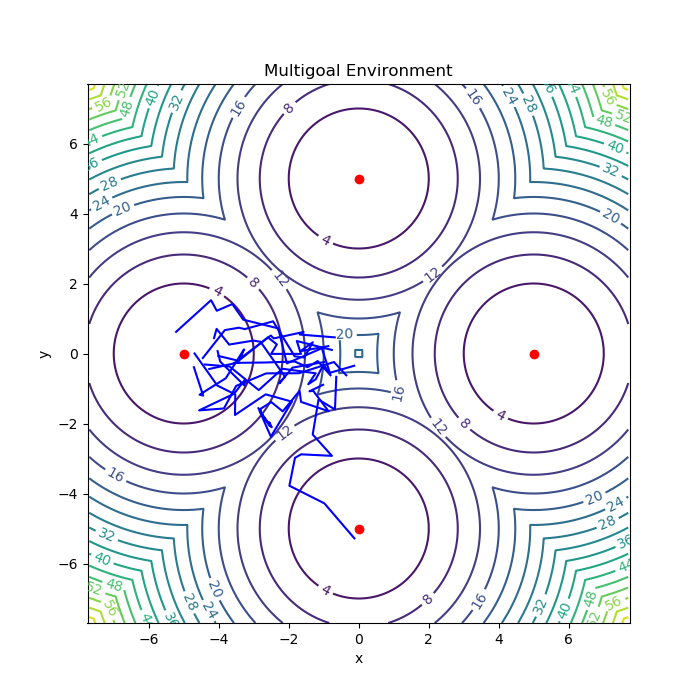

Average Reward across 10 episodes is -266.10
Reward per step of the particle is -24.39


In [25]:
agent = lambda env: torch.load('/host/final_project/model/bayes_vpg/bayes_vpg_s37/pyt_save/model.pt')
total_rewards = test_policy(agent)
print ('Average Reward across {:d} episodes is {:.2f}'.format(total_rewards[0].shape[0], np.mean(total_rewards[0])))
print ('Reward per step of the particle is {:.2f}'.format(np.mean(total_rewards[1])))